## 1. Datenimport und Initialisierung

In diesem Abschnitt werden die OpenJur-Urteilstexte aus dem Datenverzeichnis eingelesen und die technische Datenbasis für die nachfolgenden Verarbeitungsschritte geschaffen. Dazu werden die benötigten Bibliotheken importiert und die verfügbaren Textdateien identifiziert.


### 1.1 Import der benötigten Bibliotheken

Zu Beginn werden die für die weitere Verarbeitung erforderlichen Python-Bibliotheken importiert. Diese umfassen Funktionen für Dateizugriffe, reguläre Ausdrücke, Datenverarbeitung mit Pandas sowie den Export der Ergebnisse im JSON-Format.

In [1]:
import os
import re
import json
import pandas as pd

### 1.2 Einlesen der OpenJur-Urteilstexte 

Die OpenJur-Urteilstexte werden aus einem parametrierten Datenverzeichnis (DATA_DIR) eingelesen. Jedes Urteil liegt als separate Textdatei vor und wird über den Dateinamen eindeutig einer Fallkennung (case_id) zugeordnet. Zur Sicherstellung einer konsistenten Verarbeitung werden die identifizierten Textdateien sortiert. Die eingelesenen Texte bilden die Rohdatenbasis für alle nachfolgenden Verarbeitungs- und Analyse­schritte.

In [2]:
DATA_DIR = "../data/Gerichtsurteile_Openjur"

files = sorted([f for f in os.listdir(DATA_DIR) if f.lower().endswith(".txt")])

print("Pfad:", os.path.abspath(DATA_DIR))
print("Anzahl .txt:", len(files))
print("Erste 10 Dateien:", files[:10])


Pfad: c:\Users\humme\OneDrive\Dokumente\Uni Ulm\ds_law\backend\data\Gerichtsurteile_Openjur
Anzahl .txt: 2375
Erste 10 Dateien: ['2090187.txt', '2112111.txt', '2112115.txt', '2112117.txt', '2112118.txt', '2112119.txt', '2112121.txt', '2112123.txt', '2124977.txt', '2126821.txt']


---

## 2. Extraktion relevanter Urteilsbestandteile und Selektion der Landgerichtsurteile

In diesem Abschnitt werden die eingelesenen Urteilstexte weiterverarbeitet, um für die nachfolgende Analyse relevante Textbestandteile gezielt zu extrahieren. Hierzu zählen insbesondere ein begrenzter Kopfbereich zur Voranalyse sowie der Tenor als Kern der gerichtlichen Entscheidung. Die strukturierte Aufbereitung dieser Textsegmente bildet die Grundlage für Filter-, Klassifikations- und Extraktionsschritte in den folgenden Abschnitten.

### 2.1 Aufbau des DataFrames und Extraktion eines Kopfbereichs

Die eingelesenen Texte werden in einem DataFrame (`df`) gespeichert. Zusätzlich wird ein begrenzter Kopfbereich (`head`) aus den ersten Zeichen extrahiert, da strukturelle Metadaten wie Gerichtstyp, Entscheidungsart und Zitierzeilen typischerweise am Anfang des Dokuments auftreten. Dieser Kopfbereich dient als effizienter Suchraum für die spätere Identifikation von Landgerichtsurteilen.


In [3]:
rows = []
for fn in files:
    case_id = fn.replace(".txt", "")
    path = os.path.join(DATA_DIR, fn)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()
    rows.append({"case_id": case_id, "text": text})

df = pd.DataFrame(rows)
print("Gesamt eingelesen:", len(df))


Gesamt eingelesen: 2375


In [4]:
HEAD_CHARS = 8000
df["head"] = df["text"].astype(str).str.slice(0, HEAD_CHARS)

print("Head-Länge (Beispiel):", len(df.loc[0, "head"]))


Head-Länge (Beispiel): 8000


### 2.2 Extraktion des Tenors

Der Tenor enthält die eigentliche gerichtliche Entscheidung und ist daher für die inhaltliche Bewertung besonders relevant. Mithilfe regulärer Ausdrücke wird der Textabschnitt zwischen der Überschrift „Tenor“ und den nachfolgenden Abschnitten (z. B. „Tatbestand“ oder „Gründe“) extrahiert und in einer separaten Spalte gespeichert.

In [5]:
def extract_tenor(text: str) -> str:
    if not isinstance(text, str):
        return ""

    m_start = re.search(r"\bTenor\b", text, flags=re.IGNORECASE)
    if not m_start:
        return ""

    start = m_start.end()

    # Das Suchfenster nach dem Tenor wird begrenzt (robuster gegen Navigation)
    window = text[start:start + 20000]

    m_end = re.search(
        r"\b(Tatbestand|Gründe|Gruende|Entscheidungsgründe|Entscheidungsgruende)\b",
        window,
        flags=re.IGNORECASE
    )

    end = start + m_end.start() if m_end else min(len(text), start + 8000)
    return text[start:end].strip()
df["tenor"] = df["text"].apply(extract_tenor)
print("Tenor vorhanden:", (df["tenor"].str.len() > 0).sum(), "von", len(df))


Tenor vorhanden: 2362 von 2375


### 2.3 Identifikation von Landgerichtsurteilen (LG)

Die Selektion der Landgerichtsurteile erfolgt anhand einer OpenJur-spezifischen Zitierzeile im Kopfbereich (Regex: „Einfach“ gefolgt von „LG“). Auf dieser Grundlage wird eine boolesche Variable erzeugt und der Teilkorpus df_lg gebildet. Die Selektion dient als heuristischer Vorfilter auf Basis der OpenJur-Zitierzeile; eine inhaltliche Absicherung des Gerichtstyps erfolgt später über die LLM-basierte Extraktion.

In [6]:
pattern_zitierung_lg = r"Einfach\s*\n\s*LG"

df["is_landgericht"] = df["head"].str.contains(pattern_zitierung_lg, regex=True, na=False)

# Erstellung des DataFrames mit echten LG-Urteilen
df_lg = df[df["is_landgericht"] == True].copy()

print("-" * 40)
print(f"Echte LG-Urteile (über Zitierzeile): {len(df_lg)}")
print("-" * 40)

----------------------------------------
Echte LG-Urteile (über Zitierzeile): 1189
----------------------------------------


### 2.4 Segmentierung der Urteile in juristische Abschnitte
Für die spätere Extraktion werden die Urteile in juristisch sinnvolle Teile zerlegt: Rubrum, Tenor, Tatbestand und Entscheidungsgründe. Dadurch kann das Modell gezielt relevante Passagen verarbeiten.
Die Segmentierung dient dazu, um je nach Aufgabe gezielt entscheidungsrelevante Abschnitte (z. B. Tenor zur Label-Extraktion und Tatbestand/Gründe zur Merkmalsbildung) zu nutzen.


In [7]:
def split_judgment(text):
    """
    Teilt ein Urteil in Rubrum, Tenor, Tatbestand und Entscheidungsgründe auf.
    """
    segments = {
        "rubrum": "",
        "tenor": "",
        "tatbestand": "",
        "entscheidungsgruende": ""
    }
      
    # Das Rubrum ist alles vor dem Tenor
    m_tenor = re.search(r"\bTenor\b", text, re.IGNORECASE)
    m_tatbestand = re.search(r"\bTatbestand\b", text, re.IGNORECASE)
    m_gruende = re.search(r"\b(Entscheidungsgründe|Entscheidungsgruende|Gründe|Gruende)\b", text, re.IGNORECASE)
    
    if m_tenor:
        segments["rubrum"] = text[:m_tenor.start()].strip()
        
        # Tenor bis Tatbestand
        if m_tatbestand:
            segments["tenor"] = text[m_tenor.end():m_tatbestand.start()].strip()
            
            # Tatbestand bis Gründe
            if m_gruende:
                segments["tatbestand"] = text[m_tatbestand.end():m_gruende.start()].strip()
                segments["entscheidungsgruende"] = text[m_gruende.end():].strip()
            else:
                segments["tatbestand"] = text[m_tatbestand.end():].strip()
        else:
            # Falls kein Tatbestand gefunden wird, Tenor bis zum Ende oder Gründen
            if m_gruende:
                segments["tenor"] = text[m_tenor.end():m_gruende.start()].strip()
                segments["entscheidungsgruende"] = text[m_gruende.end():].strip()
            else:
                segments["tenor"] = text[m_tenor.end():].strip()
                
    return segments

# Beispielanwendung auf den Dataframe
df_lg['segments'] = df_lg['text'].apply(split_judgment)

## 3 Prompt-Generierung und Pilotierung der LLM-Extraktion (Gemini Batch)
Um API- und Token-Limits zu berücksichtigen, werden OpenJur-spezifische Navigationselemente aus dem Rubrum entfernt und alle Abschnitte in ihrer Länge begrenzt. Auf Basis dieser vorverarbeiteten Textsegmente wird ein standardisierter Prompt generiert, der die Extraktion der abgestimmten Variablen im JSON-Format steuert.
Die segmentweise Längenbegrenzung dient der Einhaltung von Token-Limits sowie der Reduktion von Kosten und Laufzeit, ohne entscheidungsrelevante Passagen (insb. Tenor und Entscheidungsgründe) zu verlieren.


### 3.1 Aufbereitung der Segmente und Definition des Extraktions-Prompts

Der Prompt wurde so konzipiert, dass er neben technischen Features (z.B. Motor, Kilometer) gezielt die Anforderungen der Aufgabenstellung erfüllt. Kernaspekte sind die Identifikation des Gerichtstyps sowie die Differenzierung der Zielvariable in Schadensersatz, Klageabweisung und prozessuale Sonderfälle („Sonstige“). Durch explizite Anweisungen zum Ausschluss von Zinsen und zur Erkennung von Streitwertbeschlüssen wird eine hohe Datenqualität für das anschließende Machine Learning sichergestellt.

In [8]:
def clean_rubrum(rubrum: str) -> str:
    if not isinstance(rubrum, str):
        return ""

    blacklist = [
        "rechtsprechung", "aktuell", "trending", "filter",
        "über openjur", "spenden", "api", "hilfe",
        "startseite", "bundesland", "gerichtsbarkeit",
        "impressum", "datenschutz", "nutzungsbedingungen",
        "fachzeitschriften", "suchen", "changelog", "einfach",
        "json", "bibtex", "ris"
    ]

    lines = []
    for line in rubrum.splitlines():
        l = line.strip().lower()
        if not l:
            continue
        if any(b in l for b in blacklist):
            continue
        lines.append(line.strip())

    return "\n".join(lines[:5])   

def slim_segments(segments):
    return {
        "rubrum": clean_rubrum(segments.get("rubrum") or "")[:2500],
        "tenor": (segments.get("tenor") or "")[:4000],
        "tatbestand": (segments.get("tatbestand") or "")[:3500],
        "entscheidungsgruende": (segments.get("entscheidungsgruende") or "")[:7000],
    }
def get_gemini_prompt(segments):
    """
    Erstellt den finalen Prompt basierend auf den Urteilssegmenten.
    """
    s = slim_segments(segments)

    prompt = f"""
Analysiere die folgenden Abschnitte eines Gerichtsurteils zum Dieselskandal und extrahiere die Variablen präzise als JSON-Liste. 

### URTEILS-BESTANDTEILE:
RUBRUM (Kopfbereich mit Gericht & Datum): 
{s['rubrum']}

TENOR (Ergebnis): 
{s['tenor']}

TATBESTAND (Sachverhalt): 
{s['tatbestand']}

ENTSCHEIDUNGSGRÜNDE (Rechtliche Würdigung): 
{s['entscheidungsgruende']}

### EXTRAKTIONS-AUFGABE:
Extrahiere folgende Variablen (bei Nichtfinden 'null' angeben):

WICHTIG (Validierung & Datenqualität):
1) **Gerichtstyp** muss explizit angegeben werden (z.B. "Landgericht", "Oberlandesgericht", "Amtsgericht").  
2) **Sonstige-Kategorie (prozessuale Dokumente):** Falls das Dokument **keine materielle Entscheidung über einen Schadensersatzanspruch** enthält (z.B. nur Streitwertfestsetzung/-beschluss, Prozesskostenhilfe/PKH, Kostenentscheidung ohne Sachentscheidung, Ablehnungsgesuch/Befangenheit, rein prozessualer Beschluss), dann setze zwingend:
   - LABEL_Anspruch_Schadensersatz = false
   - LABEL_Schadensersatzhoehe_Betrag = null
   - LABEL_Schadensersatzhoehe_Range = "Sonstige"
3) **Betrag ohne Zinsen:** LABEL_Schadensersatzhoehe_Betrag ist **ohne Zinsen/Verzugszinsen/Nebenforderungen** anzugeben.

1. **Input-Variablen (Features):**
   - Dieselmotor_Typ: (Beispiel: "EA 189", "EA 288")
   - Art_Abschalteinrichtung: (Beispiel: "Umschaltlogik", "Thermofenster")
   - KBA_Rueckruf: (Boolean: true/false - Beispiel: true)
   - Fahrzeugstatus: ("Neuwagen" oder "Gebrauchtwagen")
   - Fahrzeugmodell_Baureihe: (Beispiel: "VW Golf 2.0 TDI")
   - Update_Status: (Boolean: true/false/null - Beispiel: false)
   - Kilometerstand_Kauf: (Integer - Beispiel: 15200)
   - Kilometerstand_Klageerhebung: (Integer - Beispiel: 45000)
   - Erwartete_Gesamtlaufleistung: (Integer - Beispiel: 250000)
   - Kaufdatum: (Date YYYY-MM-DD - Beispiel: 2014-05-12)
   - Uebergabedatum: (Date YYYY-MM-DD - Beispiel: 2014-05-20)
   - Datum_Klageerhebung: (Date YYYY-MM-DD - Beispiel: 2018-11-03)
   - Beklagten_Typ: ("Händler" oder "Hersteller")
   - Datum_Urteil: (Date YYYY-MM-DD - Beispiel: 2019-12-17)
   - Kaufpreis: (Float in EUR - Beispiel: 25900.00)
   - Nacherfuellungsverlangen_Fristsetzung: ("Ja", "Nein", "Entbehrlich")
   - Klageziel: ("Rückabwicklung", "Minderung", "Schadensersatz")
   - Rechtsgrundlage: (Beispiel: "§ 826 BGB", "§ 437 BGB")

2. **Zielvariablen (Labels):**
   - LABEL_Anspruch_Schadensersatz (Boolean: true/false - Beispiel: true)
   - LABEL_Schadensersatzhoehe_Betrag (Float in EUR - Beispiel: 18450.50)
   - LABEL_Schadensersatzhoehe_Range (Beispiel: "< 5000", "5000-10000", "10000-15000", "15000-20000", "20000-25000", "> 25000", "Abgewiesen")

### AUSGABEFORMAT:
Antworte NUR mit einem validen JSON-Objekt in einer Liste:
[{{
  "case_id": null,
  "Gerichtstyp": null,
  "Dieselmotor_Typ": null,
  "Art_Abschalteinrichtung": null,
  "KBA_Rueckruf": null,
  "Fahrzeugstatus": null,
  "Fahrzeugmodell_Baureihe": null,
  "Update_Status": null,
  "Kilometerstand_Kauf": null,
  "Kilometerstand_Klageerhebung": null,
  "Erwartete_Gesamtlaufleistung": null,
  "Kaufdatum": null,
  "Uebergabedatum": null,
  "Datum_Klageerhebung": null,
  "Nachweis_Aufklaerung": null,
  "Beklagten_Typ": null,
  "Datum_Urteil": null,
  "Kaufpreis": null,
  "Nacherfuellungsverlangen_Fristsetzung": null,
  "Klageziel": null,
  "Rechtsgrundlage": null,
  "LABEL_Anspruch_Schadensersatz": null,
  "LABEL_Schadensersatzhoehe_Betrag": null,
  "LABEL_Schadensersatzhoehe_Range": null
}}]
""".strip()

    return prompt


In [ ]:
'''import time
import pandas as pd
import json
import re
import os
from google import genai

# --- 1. EINSTELLUNGEN ---
MODEL_NAME = "models/gemini-2.5-flash"
CHECKPOINT_FILE = "gemini_results_checkpoint.csv" # Sicherungsdatei

# API Key Client starten
api_key = os.getenv("GEMINI_API_KEY") 
client = genai.Client(api_key=api_key)

# --- 2. HILFSFUNKTIONEN ---
def extract_json_from_llm(text: str):
    text = re.sub(r"^```json\s*|\s*```$", "", text.strip(), flags=re.MULTILINE)
    m = re.search(r"(\[\s*\{.*?\}\s*\]|\{.*?\})", text, flags=re.DOTALL)
    if not m: raise ValueError("Kein JSON gefunden")
    return json.loads(m.group(1))

# --- 3. DER HAUPT-LAUF (ROBUST & KORREKTER ZÄHLER) ---
working_df = df_lg.copy() 
results = []
errors = []

print(f"🚀 Starte 'Pay-as-you-go' Lauf für {len(working_df)} Fälle mit {MODEL_NAME}...")
print(f"💾 Zwischenergebnisse werden alle 50 Fälle in '{CHECKPOINT_FILE}' gespeichert.")

start_time = time.time()

# KORREKTUR: Wir nutzen enumerate(), um einen echten Zähler (i) zu haben
for i, (index, row) in enumerate(working_df.iterrows()):
    case_id = row['case_id']
    
    # Retry-Logik
    max_retries = 3
    for attempt in range(max_retries):
        try:
            # 1. Prompt holen (MIT Sicherheits-Check für Strings)
            segs = row["segments"]
            if isinstance(segs, str):
                import ast
                segs = ast.literal_eval(segs)
            
            # (Hier war dein Einrückungsfehler)
            prompt = get_gemini_prompt(segs)
            
            # 2. Anfrage senden (Das fehlte in deinem Code!)
            response = client.models.generate_content(
                model=MODEL_NAME,
                contents=prompt
            )
            
            # 3. Ergebnis verarbeiten
            data = extract_json_from_llm(response.text)
            if isinstance(data, list): data = data[0]
            
            data["case_id"] = case_id
            results.append(data)
            
            # Fortschrittsanzeige & Checkpoint (nutzt jetzt 'i' statt 'index')
            if (i + 1) % 50 == 0:
                elapsed = time.time() - start_time
                
                # Checkpoint speichern
                pd.DataFrame(results).to_csv(CHECKPOINT_FILE, index=False)
                
                print(f"✅ {i + 1}/{len(working_df)} geschafft ({elapsed:.1f}s) -> 💾 Checkpoint gesichert.")
            
            break # Erfolg -> Raus aus Retry

        except Exception as e:
            error_msg = str(e)
            # Exponentielles Warten: 5s, 10s, 15s
            wait_time = 5 * (attempt + 1)
            
            if "429" in error_msg or "RESOURCE_EXHAUSTED" in error_msg:
                if attempt < max_retries - 1:
                    print(f"⏳ Limit bei {case_id}. Warte {wait_time}s (Versuch {attempt+1}/{max_retries})...")
                    time.sleep(wait_time)
                    continue
                else:
                    print(f"❌ Limit-Fehler bei {case_id} endgültig.")
                    errors.append({"case_id": case_id, "error": "429 Limit"})
            else:
                print(f"⚠️ Fehler bei {case_id}: {error_msg}")
                errors.append({"case_id": case_id, "error": error_msg})
                break

print("\n🎉 FERTIG!")
print(f"Erfolgreich extrahiert: {len(results)}")

# --- 4. FINALES SPEICHERN ---
df_final = pd.DataFrame(results)
filename = "gemini_results_paid_complete.csv"
df_final.to_csv(filename, index=False)
print(f"✅ Finale Daten gespeichert als: {filename}")

# Aufräumen: Wenn alles geklappt hat, löschen wir den Checkpoint
if os.path.exists(CHECKPOINT_FILE):
    os.remove(CHECKPOINT_FILE)
    print("🧹 Checkpoint-Datei entfernt (Job erledigt).")'''

🚀 Starte 'Pay-as-you-go' Lauf für 1189 Fälle mit models/gemini-2.5-flash...
💾 Zwischenergebnisse werden alle 50 Fälle in 'gemini_results_checkpoint.csv' gespeichert.
✅ 50/1189 geschafft (976.1s) -> 💾 Checkpoint gesichert.
✅ 100/1189 geschafft (1830.6s) -> 💾 Checkpoint gesichert.
✅ 150/1189 geschafft (2801.6s) -> 💾 Checkpoint gesichert.
✅ 200/1189 geschafft (3741.5s) -> 💾 Checkpoint gesichert.
✅ 250/1189 geschafft (4609.3s) -> 💾 Checkpoint gesichert.
✅ 300/1189 geschafft (5551.5s) -> 💾 Checkpoint gesichert.
✅ 350/1189 geschafft (6510.9s) -> 💾 Checkpoint gesichert.
✅ 400/1189 geschafft (7372.8s) -> 💾 Checkpoint gesichert.
✅ 450/1189 geschafft (8183.8s) -> 💾 Checkpoint gesichert.
✅ 500/1189 geschafft (8984.6s) -> 💾 Checkpoint gesichert.
✅ 550/1189 geschafft (9833.6s) -> 💾 Checkpoint gesichert.
✅ 600/1189 geschafft (10653.7s) -> 💾 Checkpoint gesichert.
✅ 650/1189 geschafft (11524.9s) -> 💾 Checkpoint gesichert.
✅ 700/1189 geschafft (12349.7s) -> 💾 Checkpoint gesichert.
✅ 750/1189 geschafft 

## 4 Verarbeitung der Modellantworten und Erstellung des Extraktions-Datensatzes

In diesem Abschnitt werden die Ergebnisse des direkten API-Durchlaufs (`gemini_results_paid_complete.csv`) eingelesen und mit den ursprünglichen Urteilstexten verknüpft. Um eine hohe Datenqualität für das anschließende Machine Learning zu gewährleisten, erfolgen hier zudem wichtige Bereinigungsschritte:

1.  **Daten-Merge:** Die KI-Extraktionen werden über die eindeutige `case_id` mit den Originaltexten (`df_lg`) zusammengeführt. Dabei wird sichergestellt, dass die ID in beiden Datensätzen als String behandelt wird, um Datenverlust zu vermeiden.
2.  **Bereinigung von Geldbeträgen:** Die Funktion `clean_money_robust` konvertiert diverse deutsche Währungsformate (z. B. "25.000,00 €", "1.000 Euro" oder "25.000") zuverlässig in numerische Gleitkommazahlen (`float`), indem sie Tausenderpunkte und Währungssymbole korrekt interpretiert und entfernt.
3.  **Standardisierung der Zielvariable:** Die Funktion `determine_target_label` vereinheitlicht die unterschiedlichen Rückgabeformate des Modells (z. B. "True", "yes", "1") in saubere Kategorien ("Schadensersatz", "Abgewiesen", "Sonstige"). Prozessuale Sonderfälle („Sonstige“) werden anschließend aus dem ML-Datensatz ausgeschlossen, da sie keine materielle Sachentscheidung enthalten und als Rauschen für die Klassifikation wirken.

Abschließend wird der bereinigte Gesamtdatensatz sowohl im CSV-Format (für manuelle Prüfung) als auch im Parquet-Format (für performante Weiterverarbeitung) gespeichert.

### 4.1 Bereinigung und Merging der Daten
Wir laden die Ergebnisse, bereinigen Datentypen und führen sie mit den Originaltexten zusammen.

In [8]:

%pip install pyarrow 
import pandas as pd
import numpy as np
import os
import re

RESULTS_FILENAME = "gemini_results_paid_complete.csv"

if not os.path.exists(RESULTS_FILENAME):
    raise FileNotFoundError(f"Datei {RESULTS_FILENAME} fehlt! Bitte Kapitel 3 ausführen.")

print(f"Lade Ergebnisse aus: {RESULTS_FILENAME}")
df_extracted = pd.read_csv(RESULTS_FILENAME)

df_lg["case_id"] = df_lg["case_id"].astype(str)
df_extracted["case_id"] = df_extracted["case_id"].astype(str)

#  Merge: Originaltexte (df_lg) + KI-Daten (df_extracted)
df_dataset = pd.merge(df_lg, df_extracted, on="case_id", how="inner")

print(f"Merge erfolgreich: {len(df_dataset)} Datensätze.")


def clean_money_robust(val):
    """ Wandelt Strings wie '25.000,00' oder '1000 €' sicher in Floats um. """
    if pd.isna(val) or str(val).strip().lower() in ["null", "none", "nan", ""]:
        return 0.0
    
    if isinstance(val, (int, float)):
        return float(val)

    s = str(val).strip()
    # Entferne alles außer Ziffern, Punkt, Komma, Minus
    s = re.sub(r'[^\d.,-]', '', s)
    
    # Logik für deutsche Tausenderpunkte (z.B. 25.000 -> 25000)
    if "," in s:
        s = s.replace(".", "")  # Tausender weg
        s = s.replace(",", ".") # Dezimal-Komma zu Punkt
    else:
        # Fall "25.000" (ohne Komma) -> Punkt ist Tausender
        if "." in s:
            parts = s.split(".")
            # Wenn nach dem letzten Punkt genau 3 Ziffern kommen und davor auch was steht
            if len(parts) > 1 and len(parts[-1]) == 3:
                s = s.replace(".", "")
    
    try:
        return float(s)
    except ValueError:
        return 0.0

def determine_target_label(row):
    """ Bestimmt die Zielklasse: Schadensersatz, Abgewiesen oder Sonstige. """
    
    if str(row.get("LABEL_Schadensersatzhoehe_Range")).lower() == "sonstige":
        return "Sonstige"
    
    # Anspruch (True/False prüfen)
    val = str(row.get("LABEL_Anspruch_Schadensersatz")).strip().lower()
    if val in ["true", "1", "1.0", "ja", "yes"]:
        return "Schadensersatz"
    
    return "Abgewiesen"


# Geldbeträge bereinigen
if "Kaufpreis" in df_dataset.columns:
    df_dataset["Kaufpreis_num"] = df_dataset["Kaufpreis"].apply(clean_money_robust)

if "LABEL_Schadensersatzhoehe_Betrag" in df_dataset.columns:
    df_dataset["Schadensersatz_Betrag_num"] = df_dataset["LABEL_Schadensersatzhoehe_Betrag"].apply(clean_money_robust)

# Label erstellen
df_dataset["target_label"] = df_dataset.apply(determine_target_label, axis=1)

# "Sonstige" werden entfernt, da sie prozessuale Dokumente ohne materielle Entscheidung darstellen und somit Rauschen für die ML-Modelle verursachen würden (7,2 % des Datensatzes)
df_dataset = df_dataset[df_dataset["target_label"] != "Sonstige"].copy()

df_dataset.to_parquet("lg_diesel_urteile_final.parquet", index=False)
df_dataset.to_csv("lg_diesel_urteile_final.csv", index=False)

print("-" * 30)
print("Verteilung Target-Label:")
print(df_dataset["target_label"].value_counts(dropna=False))
print(f"\nDatensatz gespeichert (Parquet & CSV).")

Note: you may need to restart the kernel to use updated packages.
Lade Ergebnisse aus: gemini_results_paid_complete.csv
Merge erfolgreich: 1189 Datensätze.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


------------------------------
Verteilung Target-Label:
target_label
Abgewiesen        572
Schadensersatz    531
Name: count, dtype: int64

Datensatz gespeichert (Parquet & CSV).


In [9]:
df_dataset['LABEL_Schadensersatzhoehe_Range'].value_counts()

LABEL_Schadensersatzhoehe_Range
Abgewiesen     576
> 25000        176
15000-20000     91
10000-15000     84
20000-25000     70
5000-10000      60
< 5000          26
Name: count, dtype: int64

### 4.2 Vorbereitung des ML-Datensatzes
Auf Basis des bereinigten Gesamtdatensatzes wird ein maschinell lernbarer Datensatz (df_ml) erstellt. Hierzu wird der Tatbestand als zentrale textuelle Informationsquelle extrahiert und mit den durch das LLM gewonnenen strukturierten Merkmalen kombiniert.

Anschließend werden die relevanten Input-Variablen (Features) sowie die Zielvariablen (Labels) explizit definiert. Fälle mit fehlenden Kerninformationen werden entfernt, und das binäre Hauptlabel (LABEL_Anspruch_Schadensersatz) wird in ein numerisches Format überführt.

Der finale ML-Datensatz wird in Trainings- und Testdaten aufgeteilt (80/20), wobei eine Stratifizierung auf dem Hauptlabel erfolgt, um eine vergleichbare Klassenverteilung in beiden Teilmengen sicherzustellen.

In [10]:
df_ml = df_dataset.copy()

df_ml['tatbestand'] = df_ml['segments'].apply(lambda x: x.get('tatbestand', '') if isinstance(x, dict) else '')

input_features = [
    "Dieselmotor_Typ",
    "Art_Abschalteinrichtung",
    "KBA_Rueckruf",
    "Fahrzeugstatus",
    "Fahrzeugmodell_Baureihe",
    "Update_Status",
    "Kilometerstand_Kauf",
    "Kilometerstand_Klageerhebung",
    "Erwartete_Gesamtlaufleistung",
    "Kaufdatum",
    "Uebergabedatum",
    "Datum_Klageerhebung",
    "Beklagten_Typ",
    "Datum_Urteil",
    "Kaufpreis_num",
    "Nacherfuellungsverlangen_Fristsetzung",
    "Klageziel",
    "Rechtsgrundlage",
]

# Labels (Y)
labels = ['LABEL_Anspruch_Schadensersatz', 'LABEL_Schadensersatzhoehe_Range']

# Filtern und Cleaning
df_ml = df_ml.dropna(subset=['LABEL_Anspruch_Schadensersatz', 'tatbestand'])
df_ml['LABEL_Anspruch_Schadensersatz'] = df_ml['LABEL_Anspruch_Schadensersatz'].astype(int)

# Datensatz auf diese Auswahl kürzen
df_ml = df_ml[['case_id', 'tatbestand'] + input_features + labels]

# Split in Train/Test (80/20) mit Stratifikation auf dem Hauptlabel
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    df_ml, test_size=0.2, random_state=42, stratify=df_ml['LABEL_Anspruch_Schadensersatz']
)

### 4.2.1 Validierung der Klassenverteilung (Stratification Check)
Zur Überprüfung der Stratifizierung wird die Klassenverteilung des Hauptlabels im Trainings- und Testdatensatz verglichen. Dadurch wird sichergestellt, dass das Verhältnis von positiven und negativen Fällen in beiden Teilmengen weitgehend identisch bzw. ausgeglichen ist.

In [11]:

def check_stratification(df_train, df_test, label_col):
    
    train_counts = df_train[label_col].value_counts()
    test_counts = df_test[label_col].value_counts()
    
    # Prozentuale Verteilung
    train_pct = df_train[label_col].value_counts(normalize=True) * 100
    test_pct = df_test[label_col].value_counts(normalize=True) * 100
    
    stats = pd.DataFrame({
        'Train Count': train_counts,
        'Train %': train_pct,
        'Test Count': test_counts,
        'Test %': test_pct
    })
    
    print(f"Verteilung für Label: {label_col}")
    print("-" * 50)
    print(stats.round(2))
    print("-" * 50)
    
    diff = abs(train_pct - test_pct).max()
    if diff < 1.0:
        print(f"Gute Stratifizierung! (Abweichung < 1%)")
    else:
        print(f"Warnung: Abweichung von {diff:.2f}% festgestellt.")


check_stratification(train_df, test_df, 'LABEL_Anspruch_Schadensersatz')

Verteilung für Label: LABEL_Anspruch_Schadensersatz
--------------------------------------------------
                               Train Count  Train %  Test Count  Test %
LABEL_Anspruch_Schadensersatz                                          
0                                      455     51.7         114   51.82
1                                      425     48.3         106   48.18
--------------------------------------------------
Gute Stratifizierung! (Abweichung < 1%)


## 5. Datenaufbereitung für maschinelles Lernen

In diesem Abschnitt werden die Urteilstexte für die nachgelagerte prädiktive Modellierung aufbereitet. Hierzu erfolgt zunächst eine juristisch angepasste Textvorverarbeitung und die Ableitung numerischer Textrepräsentationen. Die für die supervised Lernphase erforderlichen Zielvariablen werden im Rahmen der LLM-basierten Extraktion (Abschnitt 4) erzeugt und anschließend mit den Textmerkmalen zusammengeführt (Abschnitt 5.4).
Ziel der Datenaufbereitung ist es, die extrahierten Merkmale in eine konsistente, auswertbare Form zu überführen, fehlende oder uneinheitliche Angaben zu behandeln und die Zielvariablen für die spätere Analyse eindeutig zu definieren.

### 5.1 Juristische Textvorverarbeitung
Die Tatbestände der Urteile werden einer juristisch angepassten Textvorverarbeitung unterzogen. Dabei werden Datumsangaben, Jahreszahlen und allgemeine Stoppwörter entfernt, juristische Lückenfüller gefiltert und geschlechtsspezifische Begriffe vereinheitlicht.
Ziel ist es, die inhaltlich relevanten rechtlichen Begriffe zu isolieren und eine robuste textuelle Grundlage für die nachfolgende Merkmalsextraktion zu schaffen.

In [12]:
import re
import spacy
from tqdm.auto import tqdm
tqdm.pandas()

nlp = spacy.load("de_core_news_lg", disable=["ner", "parser"])

lueckenfueller = {
    'wobei', 'somit', 'jeweils', 'hinsichtlich', 'diverser', 'nebst', 'sowie', 'zudem', 
    'ferner', 'daraufhin', 'folgend', 'folgende', 'folge', 'rahmen', 'betreffen', 
    'betroffen', 'betreffend', 'hierzu', 'hierfür', 'hiervon', 'hierdurch', 
    'insbesondere', 'dafür', 'wonach', 'seinerzeit', 'damalig', 'ursprünglich', 
    'inzwischen', 'nunmehr', 'lediglich', 'einfach', 'jedenfalls', 'sodass', 
    'darstellen', 'geben', 'ausreichend', 'möglichst', 'maximal', 'bisherig', 
    'zusammenfassend', 'identisch', 'entsprechend', 'nämlich', 'somit', 'jeder', 
    'allgemein', 'gleichzeitig', 'geeignet', 'verbindlich', 'unbekannt', 'bzw', 'ca', 
    'u.a.', 'iii', 'ivm', 'samt', 'nebst', 'ehemals', 'jeweils', 'anderer', 
    'etwaig', 'möglich', 'soweit', 'zeigen', 'künftig', 'identisch', 'dar', 
    'kommen', 'weise', 'bringen', 'letzter', 'erstens', 'exakt', 'anfang', 'linie'
}

# 2. Gender-Neutralisierungs-Mapper
gender_fix = {
    'klägerin': 'kläger', 'beklagte': 'beklagter', 'händlerin': 'händler',
    'käuferin': 'käufer', 'verkäuferin': 'verkäufer', 'herstellerin': 'hersteller',
    'leasinggeberin': 'leasinggeber', 'fahrzeughalterin': 'fahrzeughalter',
    'anwältin': 'anwalt', 'prozessbevollmächtigte': 'prozessbevollmächtigter'
}

monate = {'januar', 'februar', 'märz', 'april', 'mai', 'juni', 'juli', 'august', 'september', 'oktober', 'november', 'dezember'}

def legal_preprocess(text):
    if not isinstance(text, str) or not text or len(text) < 5: return ""
    text = text.lower()
    
    # DATUMS-FILTER (auch 14.10. oder 22.09)
    text = re.sub(r'\d{1,2}\.\d{1,2}\.(?:\d{2,4})?', ' ', text)
    # Jahreszahlen entfernen
    text = re.sub(r'\b(19|20)\d{2}\b', ' ', text)
    
    doc = nlp(text)
    tokens = []
    for t in doc:
        # Lemma ziehen und lowercase für den Check
        lemma = t.lemma_.lower()
        
        # 1. Gender-Fix
        final = gender_fix.get(lemma, lemma)
        
        # 2. Whitelist
        if final in {'§', 'abs', 'sittenwidrig', 'täuschung', 'manipulation', 'abschalteinrichtung', 'thermofenster'}:
            tokens.append(final)
            continue

        # 3. Filtern (Stoppwörter, Lückenfüller, Monate, Kurzwörter)
        if (not t.is_stop and 
            final not in lueckenfueller and 
            final not in monate and
            not t.is_punct and 
            not t.is_space and 
            len(final) > 2 and 
            t.is_alpha):
            tokens.append(final)
            
    return " ".join(tokens)

try:
    train_df["cleaned_text"] = train_df["tatbestand"].progress_apply(legal_preprocess)
    test_df["cleaned_text"] = test_df["tatbestand"].progress_apply(legal_preprocess)
except:
    train_df["cleaned_text"] = train_df["tatbestand"].apply(legal_preprocess)
    test_df["cleaned_text"] = test_df["tatbestand"].apply(legal_preprocess)

print("Data Cleaning abgeschlossen.")

c:\Users\humme\OneDrive\Dokumente\Uni Ulm\ds_law\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/880 [01:15<?, ?it/s]

Data Cleaning abgeschlossen.


### 5.2 Word2Vec und TF-IDF (Hybrid-Gewichtung)

Zur semantischen Repräsentation der bereinigten Urteilstexte wird ein Word2Vec-Modell auf dem Trainingskorpus trainiert. Ergänzend werden TF-IDF-Gewichte berechnet, um
die Bedeutung einzelner Begriffe im Gesamtkorpus zu berücksichtigen.

Die TF-IDF-Werte dienen nicht als eigenständige Features, sondern werden zur gewichteten Aggregation der Word2Vec-Vektoren auf Dokumentebene verwendet.

In [13]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Word2Vec Training 
train_tokens = [str(doc).split() for doc in train_df['cleaned_text']]
print("Trainiere Word2Vec...")
w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4, sg=1, seed=42)

# 2. TF-IDF Training
# Wir berechnen, wie "wichtig" jedes Wort im gesamten Datensatz ist
print("Berechne TF-IDF Gewichte...")
tfidf = TfidfVectorizer(analyzer=lambda x: x) 
tfidf.fit(train_tokens)

# Mittelwert der IDF-Scores als Gewichtungs-Basis
word_weights = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

print(f"Hybrid-Basis bereit. Vokabular: {len(w2v_model.wv)} Wörter.")

Trainiere Word2Vec...
Berechne TF-IDF Gewichte...
Hybrid-Basis bereit. Vokabular: 7381 Wörter.


### 5.3 Hybrid-Vektorisierung (TF-IDF weighted Word2Vec)
Auf Basis des trainierten Word2Vec-Modells werden Dokumentvektoren erzeugt, indem die Wortvektoren eines Dokuments mittels TF-IDF-Gewichten aggregiert werden.
Dadurch fließen sowohl semantische Informationen als auch die globale Relevanz einzelner Begriffe in die Repräsentation ein.

In [14]:

def get_weighted_doc_vector(doc, w2v_model, weights):
    tokens = str(doc).split()
    # Nur Wörter nehmen, die in Word2Vec UND TF-IDF existieren
    valid_tokens = [t for t in tokens if t in w2v_model.wv and t in weights]
    
    if not valid_tokens:
        return np.zeros(w2v_model.vector_size)
    
    # Vektoren und ihre Gewichte sammeln
    vectors = [w2v_model.wv[t] for t in valid_tokens]
    token_weights = [weights[t] for t in valid_tokens]
    
    # Gewichteter Durchschnitt
    return np.average(vectors, axis=0, weights=token_weights)

print("Generiere gewichtete Vektoren für Train & Test...")
X_train_text = np.array([get_weighted_doc_vector(t, w2v_model, word_weights) for t in train_df['cleaned_text']])
X_test_text = np.array([get_weighted_doc_vector(t, w2v_model, word_weights) for t in test_df['cleaned_text']])

print(f"Vektorisierung abgeschlossen. Shape: {X_train_text.shape}")

Generiere gewichtete Vektoren für Train & Test...
Vektorisierung abgeschlossen. Shape: (880, 100)


### 5.4 Funktionen der Feature-Matrix
Die finale Feature-Matrix kombiniert semantische Textrepräsentationen (TF-IDF-gewichtete Word2Vec-Vektoren) mit strukturierten Falldaten.
Boolean-, numerische, kategoriale und zeitliche Variablen werden modellgerecht transformiert und anschließend mit den Textfeatures zu einer gemeinsamen Merkmalsmatrix zusammengeführt.

In [15]:
import pandas as pd
import numpy as np

def map_bool_series(s: pd.Series) -> pd.Series:
    # robust für "true/false/ja/nein/1/0/null"
    return (
        s.astype(str).str.lower().str.strip()
         .map({"true": 1, "false": 0, "1": 1, "0": 0, "ja": 1, "nein": 0, "none": np.nan, "null": np.nan, "nan": np.nan})
    )

def prepare_features(df: pd.DataFrame, text_vectors: np.ndarray) -> pd.DataFrame:
    # 1) Text-Vektoren
    emb_cols = [f"emb_{i}" for i in range(text_vectors.shape[1])]
    df_emb = pd.DataFrame(text_vectors, columns=emb_cols, index=df.index)

    # 2) Strukturierte Features
    cat_cols = [
        "Dieselmotor_Typ",
        "Art_Abschalteinrichtung",
        "Fahrzeugstatus",
        "Fahrzeugmodell_Baureihe",
        "Beklagten_Typ",
        "Nacherfuellungsverlangen_Fristsetzung",
        "Klageziel",
        "Rechtsgrundlage",
    ]
    bool_cols = ["KBA_Rueckruf", "Update_Status"]
    num_cols = [
        "Kaufpreis_num",
        "Kilometerstand_Kauf",
        "Kilometerstand_Klageerhebung",
        "Erwartete_Gesamtlaufleistung",
    ]
    date_cols = ["Kaufdatum", "Uebergabedatum", "Datum_Klageerhebung", "Datum_Urteil"]

    
    available_cat  = [c for c in cat_cols  if c in df.columns]
    available_bool = [c for c in bool_cols if c in df.columns]
    available_num  = [c for c in num_cols  if c in df.columns]
    available_date = [c for c in date_cols if c in df.columns]

    df_struct = df.copy()

    for c in available_bool:
        df_struct[c] = map_bool_series(df_struct[c])

    # Datumsfeatures in Abstände umwandeln ---
    for c in available_date:
        df_struct[c] = pd.to_datetime(df_struct[c], errors="coerce")

    # sinnvolle Delta-Features (nur wenn die Spalten da sind)
    if "Datum_Klageerhebung" in df_struct.columns and "Kaufdatum" in df_struct.columns:
        df_struct["tage_bis_klage"] = (df_struct["Datum_Klageerhebung"] - df_struct["Kaufdatum"]).dt.days

    if "Datum_Urteil" in df_struct.columns and "Datum_Klageerhebung" in df_struct.columns:
        df_struct["tage_bis_urteil"] = (df_struct["Datum_Urteil"] - df_struct["Datum_Klageerhebung"]).dt.days

    if "Datum_Klageerhebung" in df_struct.columns and "Uebergabedatum" in df_struct.columns:
        df_struct["tage_besitz_bis_klage"] = (df_struct["Datum_Klageerhebung"] - df_struct["Uebergabedatum"]).dt.days

    delta_cols = [c for c in ["tage_bis_klage", "tage_bis_urteil", "tage_besitz_bis_klage"] if c in df_struct.columns]

    
    df_cat = pd.get_dummies(df_struct[available_cat], columns=available_cat, dummy_na=True)

    df_num = df_struct[available_num + available_bool + delta_cols].apply(pd.to_numeric, errors="coerce")
    
    df_num = df_num.fillna(0)

    # Finale Matrix
    X_struct = pd.concat([df_num, df_cat], axis=1).fillna(0).astype(float)

    return pd.concat([X_struct, df_emb], axis=1)


### 5.4.1 Aufbau der finalen Feature-Matrix

In [16]:
X_train_final = prepare_features(train_df, X_train_text)
X_test_final  = prepare_features(test_df, X_test_text)

X_test_final = X_test_final.reindex(columns=X_train_final.columns, fill_value=0)

print("Finale Feature-Matrix erstellt:")
print(f"  Train: {X_train_final.shape}")
print(f"  Test:  {X_test_final.shape}")

Finale Feature-Matrix erstellt:
  Train: (880, 1416)
  Test:  (220, 1416)


### 5.4.2 Vorbereitung der Multi-Target Variablen
Die Zielvariablen werden indexbasiert an die finale Feature-Matrix angepasst, um eine exakte Übereinstimmung zwischen Merkmalen und Labels sicherzustellen.
Neben der binären Anspruchsentscheidung wird zusätzlich eine multiklassige Zielvariable für die Schadensersatzhöhe vorbereitet.

In [17]:
# 1. Target: Anspruch (Binär)
y_train_claim = train_df.loc[X_train_final.index, 'LABEL_Anspruch_Schadensersatz'].astype(int)
y_test_claim = test_df.loc[X_test_final.index, 'LABEL_Anspruch_Schadensersatz'].astype(int)

# 2. Target: Range (Multi-Class)
y_train_range = train_df.loc[X_train_final.index, 'LABEL_Schadensersatzhoehe_Range'].fillna("Kein Anspruch")
y_test_range = test_df.loc[X_test_final.index, 'LABEL_Schadensersatzhoehe_Range'].fillna("Kein Anspruch")

# Wir setzen ein Standard-y für die nachfolgenden Zellen (z.B. den Anspruch)
y_train = y_train_claim
y_test = y_test_claim

print(f"Targets synchronisiert:")
print(f"   - Features (X): {X_train_final.shape[0]} Zeilen")
print(f"   - Labels   (y): {y_train.shape[0]} Zeilen")

Targets synchronisiert:
   - Features (X): 880 Zeilen
   - Labels   (y): 880 Zeilen


In [18]:
test_df['LABEL_Anspruch_Schadensersatz'].value_counts()

LABEL_Anspruch_Schadensersatz
0    114
1    106
Name: count, dtype: int64

## 6. Analyse und Auswertung
Im folgenden Kapitel werden verschiedene überwachte Klassifikationsmodelle auf Basis der finalen Feature-Matrix evaluiert. Ziel ist es, die Vorhersage des Anspruchs auf Schadensersatz möglichst präzise zu modellieren und die Leistungsfähigkeit der jeweiligen Modelle systematisch zu vergleichen.
Die Modelle werden mittels stratifizierter Cross-Validation bewertet und anschließend auf einem separaten Testdatensatz validiert. Als zentrale Evaluationsmetriken dienen insbesondere Precision und Recall ergänzt durch F1-Score zur ganzheitlichen Einordnung der Ergebnisse.

### 6.0 Hilfsfunktion zur Modellinterpretation
Zur besseren Interpretierbarkeit der Text-Embeddings wird eine Hilfsfunktion verwendet, die einzelne Embedding-Dimensionen auf repräsentative Begriffe aus dem Word2Vec-Vokabular abbildet. Dadurch können die wichtigsten Textmerkmale der Modelle semantisch eingeordnet werden.

In [19]:
def get_top_words_for_embedding(feature_name, model, top_n=3):
    if not feature_name.startswith("emb_"):
        return feature_name 
    
    dim_idx = int(feature_name.split("_")[1])
    # Wir suchen im Vokabular nach Wörtern, deren Vektor in dieser Dimension besonders hoch ist
    try:
        # Erstelle einen Hilfsvektor, der nur in dieser einen Dimension aktiv ist
        target_vec = np.zeros(model.vector_size)
        target_vec[dim_idx] = 1.0
        sim_words = model.wv.most_similar(positive=[target_vec], topn=top_n)
        return f"{feature_name} ({', '.join([w[0] for w in sim_words])})"
    except:
        return feature_name

### 6.1 Entscheidungsbaum
Als baseline für die binäre Klassifikation von Anspruchsentscheidungen wird ein Decision Tree auf stratifizierter 5-facher Cross-Validation trainiert und validiert. Anschließend wird das binäre Klassifikationsmodell auf dem gesamten Trainingsdatensatz trainiert und mit Hilfe des Testdatensatzes evaluiert. Evaluationsmetriken sind Accuracy, Precision, Recall und F1 Score.

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import classification_report

# Cross-Validation Splits
n_folds = 5
cv_local = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Model
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight="balanced")

# Metrics
metrics = ['precision', 'recall', 'accuracy', 'f1']

# Perform Cross-Validation Training & Validation
cv_results = cross_validate(dt_model, X_train_final, y_train_claim, cv=cv_local, scoring=metrics)

print("="*40)
print("             DECISION TREE")
print("="*40 + "\n")

print("="*20)
print("Cross-Validation")
print("="*20 + "\n")
for i in range(n_folds):
    print(f"Fold {i+1}:")
    print(f"  - Accuracy:  {cv_results['test_accuracy'][i]:.4f}")
    print(f"  - Precision: {cv_results['test_precision'][i]:.4f}")
    print(f"  - Recall:    {cv_results['test_recall'][i]:.4f}")
    print(f"  - F1:    {cv_results['test_f1'][i]:.4f}")
    print("-" * 20)

print(f"\nMean Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"Mean Precision: {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std():.4f})")
print(f"Mean Recall: {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std():.4f})")
print(f"Mean F1: {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")

# Final Model Training & Evaluation on Test Dataset
dt_model.fit(X_train_final, y_train_claim)
y_pred_dt = dt_model.predict(X_test_final)

print("\n" + "="*20)
print("Test-Set")
print("="*20 + "\n")
print(classification_report(y_test_claim, y_pred_dt))

             DECISION TREE

Cross-Validation

Fold 1:
  - Accuracy:  0.6875
  - Precision: 0.6562
  - Recall:    0.7412
  - F1:    0.6961
--------------------
Fold 2:
  - Accuracy:  0.7330
  - Precision: 0.7262
  - Recall:    0.7176
  - F1:    0.7219
--------------------
Fold 3:
  - Accuracy:  0.7045
  - Precision: 0.6854
  - Recall:    0.7176
  - F1:    0.7011
--------------------
Fold 4:
  - Accuracy:  0.7330
  - Precision: 0.7209
  - Recall:    0.7294
  - F1:    0.7251
--------------------
Fold 5:
  - Accuracy:  0.6534
  - Precision: 0.6667
  - Recall:    0.5647
  - F1:    0.6115
--------------------

Mean Accuracy: 0.7023 (+/- 0.0300)
Mean Precision: 0.6911 (+/- 0.0282)
Mean Recall: 0.6941 (+/- 0.0653)
Mean F1: 0.6912 (+/- 0.0414)

Test-Set

              precision    recall  f1-score   support

           0       0.71      0.72      0.72       114
           1       0.70      0.69      0.69       106

    accuracy                           0.70       220
   macro avg       0.70   

### 6.2 Random Forest
In diesem Kapitel wird ein Random Forest Modell zur binären Klassifikation von Schadensersatzansprüchen trainiert. Zunächst trainieren und validieren wir das Ensemble-Modell auf einem stratifizierten 5-fold CV Split. Anschließend wird das binäre Klassifikationsmodell auf dem gesamten Trainingsdatensatz trainiert und mit Hilfe des Testdatensatzes evaluiert. Evaluationsmetriken sind Accuracy, Precision, Recall und F1 Score.

Zur verbesserten Interpretierbarkeit werden die wichtigsten Merkmale über die Feature Importance des Modells identifiziert und anschließend durch die Text-Embedding-Dimensionen semantisch abgebildet.

             RANDOM FOREST

Cross-Validation

Fold 1:
  - Accuracy:  0.7557
  - Precision: 0.7386
  - Recall:    0.7647
--------------------
Fold 2:
  - Accuracy:  0.8011
  - Precision: 0.8049
  - Recall:    0.7765
--------------------
Fold 3:
  - Accuracy:  0.7386
  - Precision: 0.7294
  - Recall:    0.7294
--------------------
Fold 4:
  - Accuracy:  0.7784
  - Precision: 0.7738
  - Recall:    0.7647
--------------------
Fold 5:
  - Accuracy:  0.7670
  - Precision: 0.7500
  - Recall:    0.7765
--------------------

Mean Accuracy:  0.7682 (+/- 0.0211)
Mean Precision: 0.7593 (+/- 0.0272)
Mean Recall:    0.7624 (+/- 0.0173)
Mean F1: 0.6912 (+/- 0.0414)

Test-Set

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       114
           1       0.80      0.81      0.80       106

    accuracy                           0.81       220
   macro avg       0.81      0.81      0.81       220
weighted avg       0.81      0.81      0.81       220



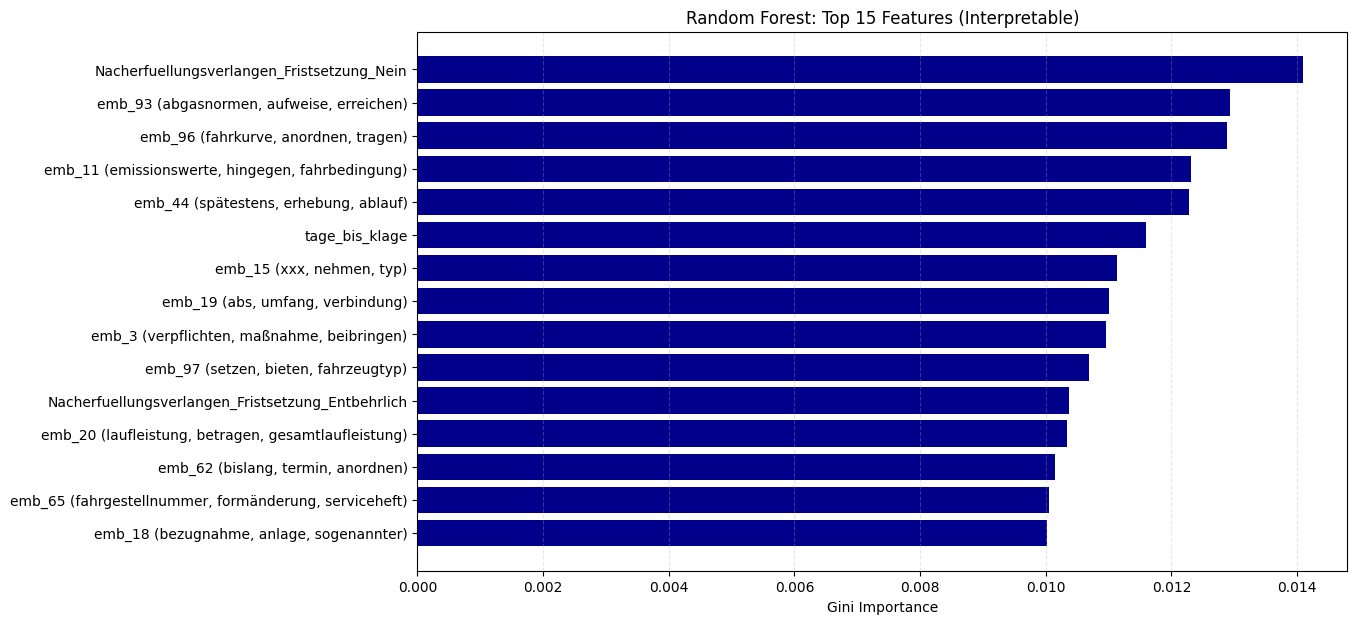

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Cross-Validation Splits
n_folds = 5
cv_local = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight="balanced")

# Metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']

# Perform CV Training & Validation
cv_results_rf = cross_validate(rf_model, X_train_final, y_train_claim, cv=cv_local, scoring=metrics)

print("="*40)
print("             RANDOM FOREST")
print("="*40 + "\n")

print("="*20)
print("Cross-Validation")
print("="*20 + "\n")
for i in range(n_folds):
    print(f"Fold {i+1}:")
    print(f"  - Accuracy:  {cv_results_rf['test_accuracy'][i]:.4f}")
    print(f"  - Precision: {cv_results_rf['test_precision'][i]:.4f}")
    print(f"  - Recall:    {cv_results_rf['test_recall'][i]:.4f}")
    print("-" * 20)

print(f"\nMean Accuracy:  {cv_results_rf['test_accuracy'].mean():.4f} (+/- {cv_results_rf['test_accuracy'].std():.4f})")
print(f"Mean Precision: {cv_results_rf['test_precision'].mean():.4f} (+/- {cv_results_rf['test_precision'].std():.4f})")
print(f"Mean Recall:    {cv_results_rf['test_recall'].mean():.4f} (+/- {cv_results_rf['test_recall'].std():.4f})")
print(f"Mean F1: {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")

# Final Model Training & Evaluation on Test Dataset
rf_model.fit(X_train_final, y_train_claim)
y_pred_rf = rf_model.predict(X_test_final)

print("\n" + "="*20)
print("Test-Set")
print("="*20 + "\n")
print(classification_report(y_test_claim, y_pred_rf))

# Visualisierung mit Word-Mapping (Nutzt die Funktion aus 6.0)
importances = rf_model.feature_importances_
feat_names = X_train_final.columns
top_indices = np.argsort(importances)[-15:]
top_importances = importances[top_indices]
top_names = [get_top_words_for_embedding(feat_names[i], w2v_model) for i in top_indices]

plt.figure(figsize=(12, 7))
plt.barh(top_names, top_importances, color='darkblue')
plt.title("Random Forest: Top 15 Features (Interpretable)")
plt.xlabel("Gini Importance")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()

### 6.3 Gradient Boosting

#### 6.3.1 Gradient Boosting ohne Hyperparameter-Tuning
Gradient Boosting wird als sequenzielles Ensemble-Modell zur binären Klassifikation des Schadensersatzanspruchs trainiert und evaluiert. Die Bewertung erfolgt zunächst mittels Training und Validierung mit Hilfe von stratifizierter 5-fach Cross-Validation. Anschließend wird das Modell auf dem gesamten Trainingsdatensatz trainiert und auf einem separaten Testdatensatz evaluiert. Evaluationsmetriken sind Accuracy, Precision, Recall und F1 Score.

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import classification_report

n_folds = 5
cv_local = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

metrics = ['accuracy', 'precision', 'recall', 'f1']

cv_results_gb = cross_validate(gb_model, X_train_final, y_train_claim, cv=cv_local, scoring=metrics)


print("="*40)
print("             GRADIENT BOOSTING")
print("="*40 + "\n")

print("="*20)
print("Cross-Validation")
print("="*20 + "\n")

for i in range(n_folds):
    print(f"Fold {i+1}:")
    print(f"  Accuracy: {cv_results_gb['test_accuracy'][i]:.4f}")
    print(f"  Precision:   {cv_results_gb['test_precision'][i]:.4f}")
    print(f"  Recall:   {cv_results_gb['test_recall'][i]:.4f}")
    print(f"  F1:   {cv_results_gb['test_f1'][i]:.4f}")
    print("-" * 20)

print(f"\nMean Accuracy: {cv_results_gb['test_accuracy'].mean():.4f} (+/- {cv_results_gb['test_accuracy'].std():.4f})")
print(f"Mean Precision:  {cv_results_gb['test_precision'].mean():.4f} (+/- {cv_results_gb['test_precision'].std():.4f})")
print(f"Mean Recall:  {cv_results_gb['test_recall'].mean():.4f} (+/- {cv_results_gb['test_recall'].std():.4f})")
print(f"Mean F1:  {cv_results_gb['test_f1'].mean():.4f} (+/- {cv_results_gb['test_f1'].std():.4f})")

# Training & Evaluation auf Test-Set
gb_model.fit(X_train_final, y_train_claim)
y_pred_gb = gb_model.predict(X_test_final)

print("\n" + "="*20)
print("Test-Set")
print("="*20 + "\n")
print(classification_report(y_test_claim, y_pred_gb))

             GRADIENT BOOSTING

Cross-Validation

Fold 1:
  Accuracy: 0.7898
  Precision:   0.7667
  Recall:   0.8118
  F1:   0.7886
--------------------
Fold 2:
  Accuracy: 0.8239
  Precision:   0.7935
  Recall:   0.8588
  F1:   0.8249
--------------------
Fold 3:
  Accuracy: 0.7670
  Precision:   0.7292
  Recall:   0.8235
  F1:   0.7735
--------------------
Fold 4:
  Accuracy: 0.8011
  Precision:   0.7841
  Recall:   0.8118
  F1:   0.7977
--------------------
Fold 5:
  Accuracy: 0.7330
  Precision:   0.7159
  Recall:   0.7412
  F1:   0.7283
--------------------

Mean Accuracy: 0.7830 (+/- 0.0310)
Mean Precision:  0.7579 (+/- 0.0304)
Mean Recall:  0.8094 (+/- 0.0382)
Mean F1:  0.7826 (+/- 0.0319)

Test-Set

              precision    recall  f1-score   support

           0       0.78      0.73      0.75       114
           1       0.73      0.78      0.75       106

    accuracy                           0.75       220
   macro avg       0.76      0.76      0.75       220
weighted a

#### 6.3.2 Visualisierung Gradient Boosting ohne Tuning
Zur verbesserten Interpretation des Gradient-Boosting Modells werden im Folgenden die relativen Feature-Importances analysiert. Es werden sowohl strukturierte Merkmale, als auch Text-Embedding-Dimensionen berücksichtigt, deren semantische Bedeutung über eine Wortprojektion nachvollziehbar gemacht wird.

Die Grafik zeigt die 15 einflussreichsten Merkmale für die Vorhersage des Schadensersatzanspruchs.

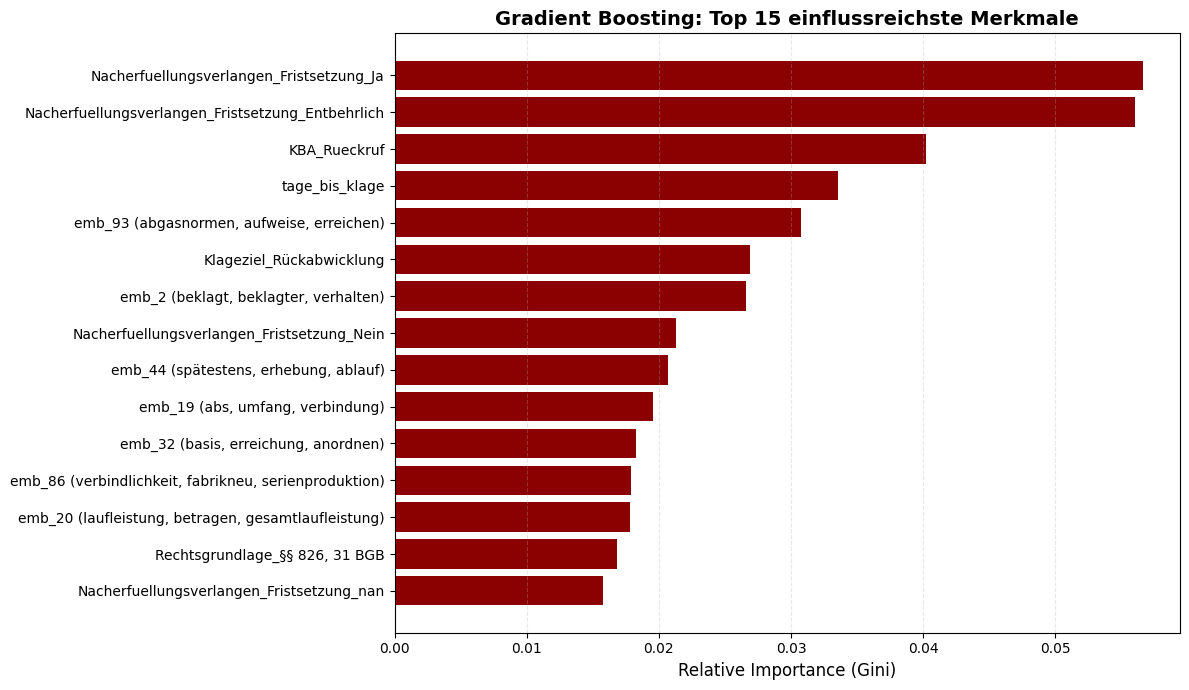

In [23]:
import numpy as np
import matplotlib.pyplot as plt

importances_gb = gb_model.feature_importances_
feat_names = X_train_final.columns

top_indices_gb = np.argsort(importances_gb)[-15:]
top_importances_gb = importances_gb[top_indices_gb]

top_names_gb = [get_top_words_for_embedding(feat_names[i], w2v_model) for i in top_indices_gb]

plt.figure(figsize=(12, 7))
plt.barh(top_names_gb, top_importances_gb, color='darkred')
plt.title("Gradient Boosting: Top 15 einflussreichste Merkmale", fontsize=14, fontweight='bold')
plt.xlabel("Relative Importance (Gini)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 6.3.3 Gradient Boosting mit Hyperparameter-Tuning
Für Gradient Boosting wird ein GridSearchCV durchgeführt, um zentrale Hyperparameter (Tiefe, Lernrate, Subsampling) zu optimieren. Als Optimierungsmetrik wird der F1-Score verwendet, da er den harmonischen Mittelwert von Precision und Recall wiederspiegelt. Die Metriken Precision und Recall werden zusätzlich aufgeführt. Das beste Modell wird anschließend per Cross-Validation validiert und auf dem separaten Testdatensatz evaluiert.

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report

n_folds = 5
cv_local = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']

gb_base = GradientBoostingClassifier(
    n_estimators=420,
    n_iter_no_change=30,
    # validation_fraction=0.1,
    random_state=42
)

param_grid = {
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.8, 0.9]
}

print("Starte GridSearchCV (Tuning)...")
grid_search = GridSearchCV(
    estimator=gb_base,
    param_grid=param_grid,
    cv=cv_local,
    scoring='f1', 
    n_jobs=-1
)
grid_search.fit(X_train_final, y_train_claim)

best_gb_model = grid_search.best_estimator_

print("\n" + "="*45)
print("ANALYSE DER BESTEN PARAMETER")
print(f"Parameter: {grid_search.best_params_}")
print("="*45)

cv_results_final = cross_validate(
    best_gb_model, X_train_final, y_train_claim, 
    cv=cv_local, 
    scoring=scoring_metrics
)

for i in range(n_folds):
    print(f"Fold {i+1}:")
    print(f"  - Accuracy: {cv_results_final['test_accuracy'][i]:.4f}")
    print(f"  - Precision: {cv_results_final['test_precision'][i]:.4f}")
    print(f"  - Recall:   {cv_results_final['test_recall'][i]:.4f}")
    print(f"  - F1: {cv_results_final['test_f1'][i]:.4f}")
    print("-" * 25)

print(f"\nMean Accuracy: {cv_results_final['test_accuracy'].mean():.4f} (+/- {cv_results_final['test_accuracy'].std():.4f})")
print(f"Mean Recall:   {cv_results_final['test_recall'].mean():.4f} (+/- {cv_results_final['test_recall'].std():.4f})")
print(f"Mean Precision: {cv_results_final['test_precision'].mean():.4f} (+/- {cv_results_final['test_precision'].std():.4f})")
print(f"Mean F1: {cv_results_final['test_f1'].mean():.4f} (+/- {cv_results_final['test_f1'].std():.4f})")


print("\n" + "="*20)
print("Test-Set")
print("="*20 + "\n")
y_pred_gb_opt = best_gb_model.predict(X_test_final)
print(classification_report(y_test_claim, y_pred_gb_opt))

print(f"-> Info: Das Modell nutzte {len(best_gb_model.estimators_)} Bäume.")

Starte GridSearchCV (Tuning)...

ANALYSE DER BESTEN PARAMETER
Parameter: {'learning_rate': 0.01, 'max_depth': 4, 'subsample': 0.8}
Fold 1:
  - Accuracy: 0.8011
  - Precision: 0.7660
  - Recall:   0.8471
  - F1: 0.8045
-------------------------
Fold 2:
  - Accuracy: 0.8409
  - Precision: 0.8132
  - Recall:   0.8706
  - F1: 0.8409
-------------------------
Fold 3:
  - Accuracy: 0.7670
  - Precision: 0.7444
  - Recall:   0.7882
  - F1: 0.7657
-------------------------
Fold 4:
  - Accuracy: 0.8182
  - Precision: 0.8046
  - Recall:   0.8235
  - F1: 0.8140
-------------------------
Fold 5:
  - Accuracy: 0.7670
  - Precision: 0.7500
  - Recall:   0.7765
  - F1: 0.7630
-------------------------

Mean Accuracy: 0.7989 (+/- 0.0289)
Mean Recall:   0.8212 (+/- 0.0352)
Mean Precision: 0.7756 (+/- 0.0282)
Mean F1: 0.7976 (+/- 0.0297)

Test-Set

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       114
           1       0.75      0.81      0.78     

#### 6.3.4 Interpretation des optimierten Hybrid-Modells (Feature Importances)
Für das über GridSearch optimierte Gradient-Boosting Modell werden die Feature Importances analysiert, um die wichtigsten strukturierten Merkmale und textbasierten Embedding-Dimensionen zu identifizieren. Da die Textrepräsentation TF-IDF-gewichtet ist, spiegeln die wichtigsten Embeddings insbesondere juristisch saliente Begriffe wider. Die Grafik zeigt die 15 einflussreichsten Features.

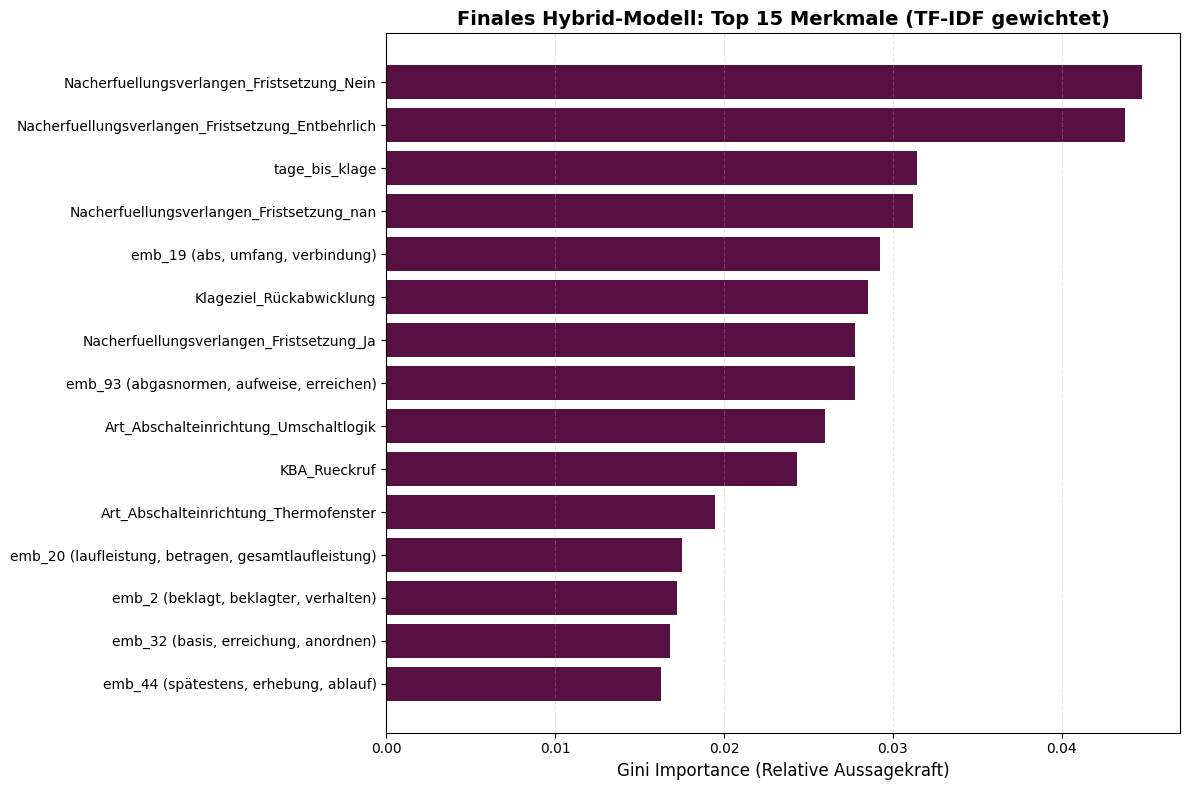

In [25]:
import numpy as np
import matplotlib.pyplot as plt

importances_final = best_gb_model.feature_importances_
feature_names = X_train_final.columns

indices_final = np.argsort(importances_final)[-15:]

top_values_final = importances_final[indices_final]
top_labels_final = [get_top_words_for_embedding(feature_names[i], w2v_model) for i in indices_final]

plt.figure(figsize=(12, 8))
plt.barh(top_labels_final, top_values_final, color='#580f41') 
plt.title("Finales Hybrid-Modell: Top 15 Merkmale (TF-IDF gewichtet)", fontsize=14, fontweight='bold')
plt.xlabel("Gini Importance (Relative Aussagekraft)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Evalutation der Klassifikationsmodelle
Für die binäre Vorhersage des Schadensersatzanspruchs wurde das durch GridSearch optimierte Gradient-Boosting Modell als bestes Modell ausgewählt. Ausschlaggebend war der höchste F1-Score in der Cross-Validation (0.80) sowie ein besonders hoher Recall für Anspruchsfälle (0.85 auf dem Test Set). Da das Modell Anspruchsfälle sehr zuverlässig identifiziert, eignet es sich optimal als vorgelagerte Entscheidungsstufe für die nachgelagerte Vorhersage der Schadensersatzhöhe, welche ausschließlich für positive Anspruchsfälle durchgeführt wird.

## 7. Vorhersage der Schadensersatzhöhe (Range-Klassifikation)

Für Fälle mit positivem Schadensersatzanspruch wird die Höhe des zugesprochenen Betrags in drei Klassen vorhergesagt: **LOW** (< 10.000 EUR), **MID** (10.000–20.000 EUR) und **HIGH** (> 20.000 EUR). Die Klasse LOW ist mit nur 17 % der Trainingsfälle deutlich unterrepräsentiert, was gezielte Maßnahmen erfordert.

In diesem Kapitel werden drei Ansätze kombiniert, um die Vorhersagequalität insbesondere für die Minderheitsklasse zu verbessern:
1. **Range-spezifischer Embeddingspace**: Neutraining des Word2Vec-Modells ausschließlich auf den 404 Range-Trainingsfällen, um die sprachlichen Muster der Schadenshöhe besser abzubilden.
2. **Domänenspezifische Ratio-Features**: Sieben zusätzliche Features, die die gerichtliche Schadensformel (Nutzungsquote, Schadensproxy etc.) direkt als numerische Merkmale kodieren.
3. **BorderlineSMOTE + class_weight="balanced"**: Synthetische Erzeugung von LOW-Trainingsbeispielen an der Entscheidungsgrenze in Kombination mit einer balancierten Verlustfunktion.

### 7.1 Aufbau des Range-Datensatzes und Train/Test-Split

Aus dem ML-Datensatz werden alle Fälle ohne Schadensersatzanspruch entfernt. Die ursprünglich feingranularen Betragsintervalle werden auf drei Klassen abgebildet (LOW / MID / HIGH) und stratifiziert in Trainings- und Testset aufgeteilt. Anschließend wird ein range-spezifisches Word2Vec-Modell geladen bzw. trainiert und die Feature-Matrix zusammengestellt.

Die finale Feature-Matrix umfasst **741 Merkmale** aus drei Gruppen:

- **100 W2V-Embeddings**: TF-IDF-gewichtete Dokumentvektoren aus einem range-spezifisch trainierten Word2Vec-Modell.
- **~634 strukturierte Features**: One-Hot-kodierte kategoriale Variablen (Fahrzeughersteller, Motorbezeichnung, Gericht etc.) sowie numerische und zeitliche Merkmale (Kaufpreis, Kilometerstände, Datumsdifferenzen).
- **7 domänenspezifische Ratio-Features**, abgeleitet aus der gerichtlichen Schadensformel:

| Feature | Berechnung | Bedeutung |
|---|---|---|
| `nutzungsquote` | km_Klage / Gesamtlaufleistung | Anteil der Lebensdauer, der bereits gefahren wurde |
| `schadensproxy` | Kaufpreis × (1 − nutzungsquote) | Geschätzter Restschaden nach Nutzungsabzug |
| `km_gefahren` | km_Klage − km_Kauf | Seit Kauf gefahrene Kilometer |
| `anteil_gefahren` | km_gefahren / Gesamtlaufleistung | Anteil der Gesamtlaufleistung seit Kauf |
| `preis_pro_km` | Kaufpreis / Gesamtlaufleistung | Kaufpreis pro Laufleistungskilometer |
| `wertminderung_pro_km` | preis_pro_km × km_gefahren | Kumulierte Wertminderung seit Kauf |
| `log_kaufpreis` | log(1 + Kaufpreis) | Logarithmierter Kaufpreis (Varianzstabilisierung) |

In [26]:
from sklearn.model_selection import train_test_split

# --- Range-Datensatz: nur Fälle mit positivem Anspruch ---
df_range = df_ml[df_ml["LABEL_Anspruch_Schadensersatz"] == 1].copy()

def map_range_3(val):
    s = str(val).replace(" ", "") if val is not None else ""
    if s in {"<5000", "5000-10000"}:
        return "LOW"
    if s in {"10000-15000", "15000-20000"}:
        return "MID"
    if s in {"20000-25000", ">25000"}:
        return "HIGH"
    return np.nan

df_range["LABEL_Range_3"] = df_range["LABEL_Schadensersatzhoehe_Range"].apply(map_range_3)
df_range = df_range.dropna(subset=["LABEL_Range_3"]).copy()

train_range_df, test_range_df = train_test_split(
    df_range, test_size=0.2, random_state=42,
    stratify=df_range["LABEL_Range_3"]
)

print(f"Range-Datensatz: {len(df_range)} Fälle (Train={len(train_range_df)}, Test={len(test_range_df)})")
print(f"\nKlassenverteilung (Train):")
print(train_range_df["LABEL_Range_3"].value_counts().sort_index())

# --- Feature-Pipeline ---
# True = Feature-Matrizen aus Cache laden (reproduzierbar, ~0.71 F1)
# False = Pipeline komplett live ausfuehren (W2V-Training, Ergebnisse variieren ±5%)
USE_CACHED_FEATURES = False

import pickle
from gensim.models import Word2Vec

if "cleaned_text" not in train_range_df.columns:
    train_range_df["cleaned_text"] = train_range_df["tatbestand"].apply(legal_preprocess)
    test_range_df["cleaned_text"]  = test_range_df["tatbestand"].apply(legal_preprocess)

if USE_CACHED_FEATURES:
    # --- Vorberechnete Feature-Matrizen laden ---
    with open("range_features.pkl", "rb") as f:
        _saved = pickle.load(f)
    X_train_range_opt = _saved["X_train"]
    X_test_range_opt = _saved["X_test"]

    # W2V-Modell laden (fuer Feature-Importance-Labels)
    w2v_range = Word2Vec.load("w2v_range.model")

    # Labels passend zum Cache-Index zuweisen
    y_train_range = train_range_df["LABEL_Range_3"].reset_index(drop=True).iloc[:len(X_train_range_opt)]
    y_test_range = test_range_df["LABEL_Range_3"].reset_index(drop=True).iloc[:len(X_test_range_opt)]

    print(f"Feature-Matrix aus Cache geladen: {X_train_range_opt.shape[1]} Features")

else:
    # --- Range-spezifisches Word2Vec-Modell trainieren ---
    import random, os
    random.seed(42); np.random.seed(42); os.environ["PYTHONHASHSEED"] = "42"

    train_tokens_range = [str(doc).split() for doc in train_range_df["cleaned_text"]]
    w2v_range = Word2Vec(
        sentences=train_tokens_range,
        vector_size=100, window=5, min_count=2,
        workers=1, sg=1, seed=45
    )

    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf_range = TfidfVectorizer(analyzer=lambda x: x)
    tfidf_range.fit(train_tokens_range)
    word_weights_range = dict(zip(tfidf_range.get_feature_names_out(), tfidf_range.idf_))

    print(f"Range-W2V Vokabular: {len(w2v_range.wv)} Wörter")

    # --- Embeddings und Feature-Matrix ---
    X_train_range_text_opt = np.array([
        get_weighted_doc_vector(t, w2v_range, word_weights_range)
        for t in train_range_df["cleaned_text"]
    ])
    X_test_range_text_opt = np.array([
        get_weighted_doc_vector(t, w2v_range, word_weights_range)
        for t in test_range_df["cleaned_text"]
    ])

    X_train_range_opt = prepare_features(train_range_df, X_train_range_text_opt)
    X_test_range_opt = prepare_features(test_range_df, X_test_range_text_opt)
    X_test_range_opt = X_test_range_opt.reindex(columns=X_train_range_opt.columns, fill_value=0)

    # --- Juristische Ratio-Features ---
    def add_domain_ratios(X, df):
        kaufpreis = pd.to_numeric(df.get("Kaufpreis_num", 0), errors="coerce").fillna(0)
        km_kauf = pd.to_numeric(df.get("Kilometerstand_Kauf", 0), errors="coerce").fillna(0)
        km_klage = pd.to_numeric(df.get("Kilometerstand_Klageerhebung", 0), errors="coerce").fillna(0)
        gesamt_km = pd.to_numeric(df.get("Erwartete_Gesamtlaufleistung", 0), errors="coerce").fillna(0)

        def safe_ratio(num, denom, fill=0.0):
            return pd.Series(np.where(denom > 0, num / denom, fill), index=df.index).fillna(fill)

        km_gefahren = (km_klage - km_kauf).clip(lower=0)
        nutzungsquote = safe_ratio(km_klage, gesamt_km)
        X["nutzungsquote"] = nutzungsquote.values
        X["schadensproxy"] = (kaufpreis * (1 - nutzungsquote)).clip(lower=0).values
        X["km_gefahren"] = km_gefahren.values
        X["anteil_gefahren"] = safe_ratio(km_gefahren, gesamt_km).values
        X["preis_pro_km"] = safe_ratio(kaufpreis, gesamt_km).values
        X["wertminderung_pro_km"] = (safe_ratio(kaufpreis, gesamt_km) * km_gefahren).values
        X["log_kaufpreis"] = np.log1p(kaufpreis).values
        return X

    X_train_range_opt = add_domain_ratios(X_train_range_opt, train_range_df)
    X_test_range_opt = add_domain_ratios(X_test_range_opt, test_range_df)
    X_test_range_opt = X_test_range_opt.reindex(columns=X_train_range_opt.columns, fill_value=0)

    # Labels indexbasiert an Feature-Matrix koppeln
    y_train_range = train_range_df.loc[X_train_range_opt.index, "LABEL_Range_3"]
    y_test_range = test_range_df.loc[X_test_range_opt.index, "LABEL_Range_3"]

    print(f"Feature-Matrix (live berechnet): {X_train_range_opt.shape[1]} Features")

print(f"Train: {X_train_range_opt.shape[0]} x {X_train_range_opt.shape[1]}, Test: {X_test_range_opt.shape[0]} x {X_test_range_opt.shape[1]}")

Range-Datensatz: 506 Fälle (Train=404, Test=102)

Klassenverteilung (Train):
LABEL_Range_3
HIGH    195
LOW      69
MID     140
Name: count, dtype: int64
Range-W2V Vokabular: 5348 Wörter
Feature-Matrix (live berechnet): 741 Features
Train: 404 x 741, Test: 102 x 741


In [27]:
print("word_weights_range" in globals())


True


### 7.2 Resampling mit BorderlineSMOTE: Ausgleich der Klassenimbalance

Die Klassenverteilung im Trainingsset ist stark ungleich (HIGH ≈ 48%, MID ≈ 35%, LOW ≈ 17%). Dies führt dazu, dass das Modell die Minderheitsklasse LOW systematisch unterklassifiziert.

**BorderlineSMOTE** ist eine Variante von SMOTE, die synthetische Beispiele gezielt in der Nähe der Entscheidungsgrenze erzeugt – also dort, wo die Klassen am schwierigsten zu trennen sind. Im Vergleich zu regulärem SMOTE verbessert dies insbesondere den Recall der LOW-Klasse, da die synthetischen Trainingsbeispiele genau die kritischen Grenzfälle zwischen LOW und MID adressieren.

Ergänzend wird `class_weight="balanced"` im HistGradientBoosting-Klassifikator gesetzt, was die Verlustfunktion zusätzlich zugunsten seltener Klassen gewichtet.

In [28]:
%pip install imbalanced-learn

from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_range_opt, y_train_range
)

print("Klassenverteilung vor SMOTE:")
print(pd.Series(Counter(y_train_range)).sort_index())
print(f"\nKlassenverteilung nach BorderlineSMOTE:")
print(pd.Series(Counter(y_train_resampled)).sort_index())


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Klassenverteilung vor SMOTE:
HIGH    195
LOW      69
MID     140
dtype: int64

Klassenverteilung nach BorderlineSMOTE:
HIGH    195
LOW     195
MID     195
dtype: int64


### 7.3 Optimiertes Modell: HistGradientBoosting mit BorderlineSMOTE und erweiterten Features

Als Klassifikator wird **HistGradientBoostingClassifier** eingesetzt – eine effiziente, histogrammbasierte Variante des Gradient Boosting, die nativ mit fehlenden Werten umgehen kann und durch `class_weight="balanced"` die Klassenimbalance zusätzlich adressiert.

Die Cross-Validation wird auf den optimierten Features durchgeführt, wobei BorderlineSMOTE innerhalb jedes CV-Folds angewendet wird, um Data Leakage zu vermeiden.

In [29]:
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

hgb_range = HistGradientBoostingClassifier(
    max_iter=300,
    learning_rate=0.05,
    max_depth=5,
    class_weight="balanced",
    random_state=42
)

# BorderlineSMOTE innerhalb der CV-Pipeline (kein Data Leakage)
smote_pipeline = ImbPipeline([
    ("smote", BorderlineSMOTE(random_state=42)),
    ("clf", hgb_range)
])

cv_range_opt = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_opt = cross_validate(
    smote_pipeline,
    X_train_range_opt,
    y_train_range,
    cv=cv_range_opt,
    scoring=["accuracy", "f1_macro"]
)

print("Optimiertes Modell – CV Ergebnisse (Range-Embeddings + Ratios + BorderlineSMOTE + HistGB):")
print(f"Mean Accuracy:  {cv_results_opt['test_accuracy'].mean():.4f}")
print(f"Mean F1 (macro): {cv_results_opt['test_f1_macro'].mean():.4f}")

Optimiertes Modell – CV Ergebnisse (Range-Embeddings + Ratios + BorderlineSMOTE + HistGB):
Mean Accuracy:  0.6759
Mean F1 (macro): 0.6195


### 7.4 Testset-Validierung (optimiertes Modell)

Das finale Modell wird auf dem BorderlineSMOTE-resampleten Trainingsset trainiert und anschließend auf dem unveränderten Testsplit evaluiert. Der Classification Report zeigt die Leistung pro Klasse (LOW/MID/HIGH) und dient als Grundlage für die Interpretation typischer Fehlklassifikationen zwischen benachbarten Betragskategorien.

In [30]:
# Training auf BorderlineSMOTE-resampletem Trainingsset
hgb_range_final = HistGradientBoostingClassifier(
    max_iter=300,
    learning_rate=0.05,
    max_depth=5,
    class_weight="balanced",
    random_state=42
)
hgb_range_final.fit(X_train_resampled, y_train_resampled)

# Vorhersage auf dem Testset
y_pred_range_opt = hgb_range_final.predict(X_test_range_opt)

print("FINALER TESTSET-BERICHT (OPTIMIERTES RANGE-MODELL):")
print(classification_report(y_test_range, y_pred_range_opt))

from sklearn.metrics import f1_score, accuracy_score
f1_opt = f1_score(y_test_range, y_pred_range_opt, average="macro")
acc_opt = accuracy_score(y_test_range, y_pred_range_opt)
print(f"Macro-F1:  {f1_opt:.4f}")
print(f"Accuracy:  {acc_opt:.4f}")

FINALER TESTSET-BERICHT (OPTIMIERTES RANGE-MODELL):
              precision    recall  f1-score   support

        HIGH       0.84      0.82      0.83        50
         LOW       0.55      0.35      0.43        17
         MID       0.67      0.80      0.73        35

    accuracy                           0.74       102
   macro avg       0.68      0.66      0.66       102
weighted avg       0.73      0.74      0.73       102

Macro-F1:  0.6614
Accuracy:  0.7353


### 7.5 Konfusionsmatrix

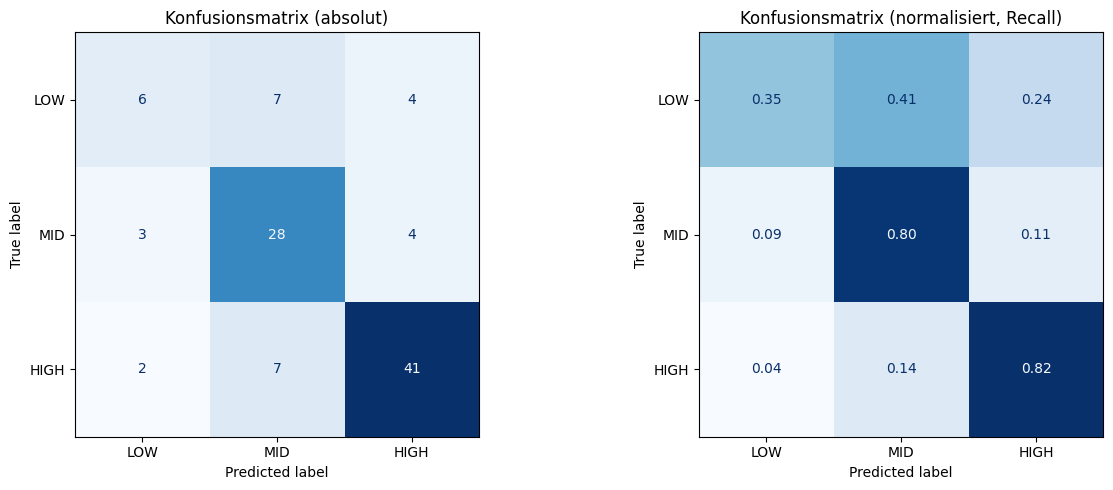

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

labels_order = ["LOW", "MID", "HIGH"]
cm = confusion_matrix(y_test_range, y_pred_range_opt, labels=labels_order)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Absolute Werte
ConfusionMatrixDisplay(cm, display_labels=labels_order).plot(
    ax=axes[0], cmap="Blues", colorbar=False, values_format="d"
)
axes[0].set_title("Konfusionsmatrix (absolut)")

# Normalisiert (Recall pro Klasse)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(cm_norm, display_labels=labels_order).plot(
    ax=axes[1], cmap="Blues", colorbar=False, values_format=".2f"
)
axes[1].set_title("Konfusionsmatrix (normalisiert, Recall)")

plt.tight_layout()
plt.show()

### 7.6 Vorhersagewahrscheinlichkeiten pro Klasse

C:\Users\humme\AppData\Local\Temp\ipykernel_34168\2177191386.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\humme\AppData\Local\Temp\ipykernel_34168\2177191386.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\humme\AppData\Local\Temp\ipykernel_34168\2177191386.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


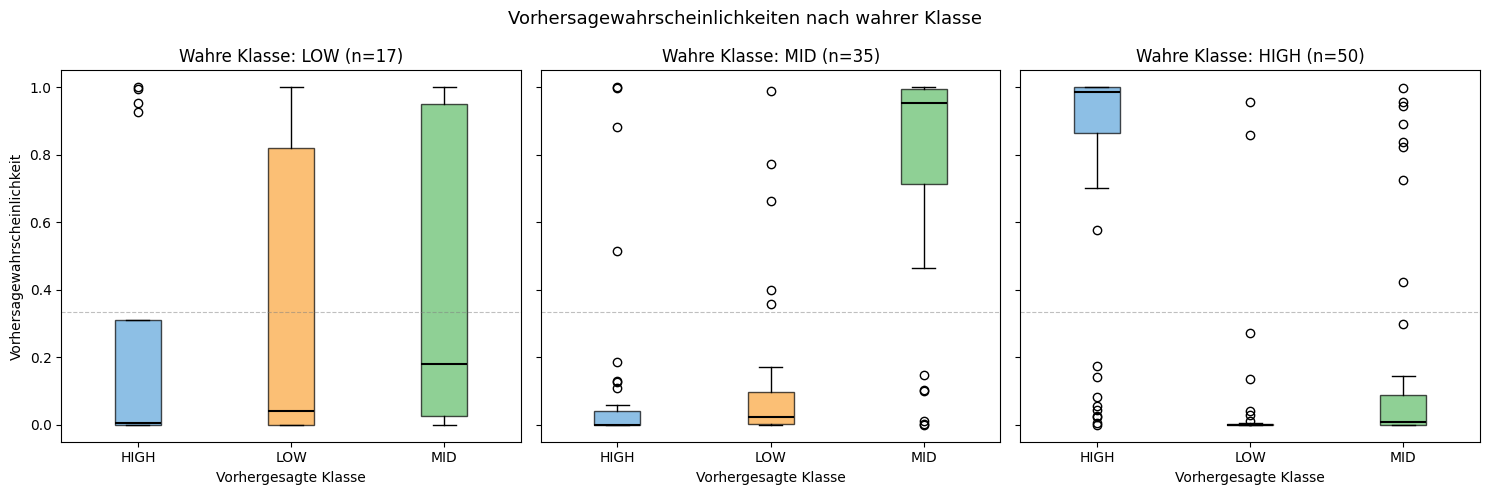

In [32]:
proba = hgb_range_final.predict_proba(X_test_range_opt)
class_labels = hgb_range_final.classes_

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, true_cls in zip(axes, ["LOW", "MID", "HIGH"]):
    mask = y_test_range.values == true_cls
    proba_subset = proba[mask]
    bp = ax.boxplot(
        [proba_subset[:, i] for i in range(len(class_labels))],
        labels=class_labels, patch_artist=True,
        medianprops=dict(color="black", linewidth=1.5)
    )
    colors = ["#5DA5DA", "#FAA43A", "#60BD68"]
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.set_title(f"Wahre Klasse: {true_cls} (n={mask.sum()})")
    ax.set_xlabel("Vorhergesagte Klasse")
    if ax == axes[0]:
        ax.set_ylabel("Vorhersagewahrscheinlichkeit")
    ax.set_ylim(-0.05, 1.05)
    ax.axhline(1/3, color="gray", linestyle="--", linewidth=0.8, alpha=0.5)

plt.suptitle("Vorhersagewahrscheinlichkeiten nach wahrer Klasse", fontsize=13)
plt.tight_layout()
plt.show()

Die Boxplots zeigen die vom Modell geschätzten Klassenwahrscheinlichkeiten, aufgeschlüsselt nach der wahren Klasse. HIGH-Fälle werden mit hoher Konfidenz korrekt zugeordnet, während LOW-Fälle häufig ähnliche Wahrscheinlichkeiten für LOW und MID aufweisen – ein Ausdruck der starken Feature-Überlappung zwischen diesen Klassen. Die gestrichelte Linie markiert die Zufallswahrscheinlichkeit (1/3).

### 7.7 Feature Importance und Klassenverteilung

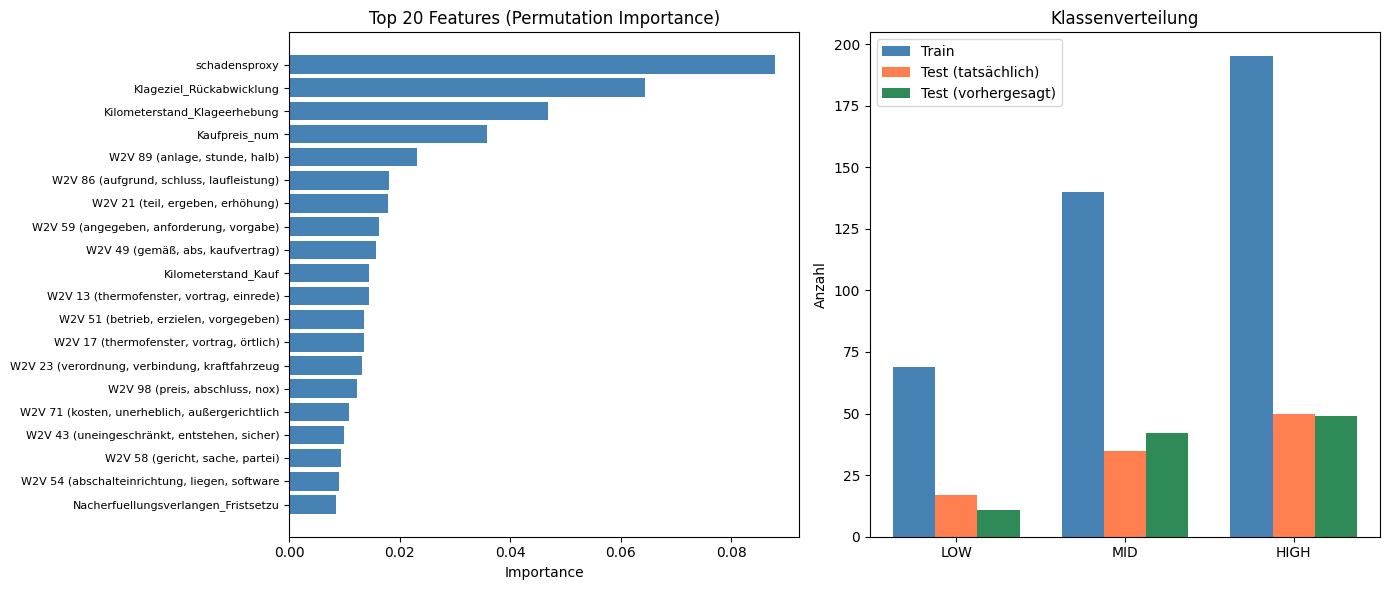

In [33]:
from sklearn.inspection import permutation_importance

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Feature Importance (Top 20, Permutation Importance) ---
perm = permutation_importance(hgb_range_final, X_test_range_opt, y_test_range,
                              n_repeats=10, random_state=42, scoring="f1_macro")
importances = perm.importances_mean
feat_names_raw = X_train_range_opt.columns.tolist()

# Embedding-Dimensionen interpretierbar benennen: emb_X -> Top-Wörter aus W2V
def label_feature(name):
    if not name.startswith("emb_"):
        return str(name)[:35]
    dim_idx = int(name.split("_")[1])
    try:
        target_vec = np.zeros(w2v_range.vector_size)
        target_vec[dim_idx] = 1.0
        top_words = w2v_range.wv.most_similar(positive=[target_vec], topn=3)
        return f"W2V {dim_idx} ({', '.join(w[0] for w in top_words)})"[:45]
    except Exception:
        return f"W2V Dim {dim_idx}"

feat_labels = [label_feature(n) for n in feat_names_raw]
feat_labels = np.array(feat_labels)
top_idx = np.argsort(importances)[-20:]

axes[0].barh(range(len(top_idx)), importances[top_idx], color="steelblue")
axes[0].set_yticks(range(len(top_idx)))
axes[0].set_yticklabels(feat_labels[top_idx], fontsize=8)
axes[0].set_xlabel("Importance")
axes[0].set_title("Top 20 Features (Permutation Importance)")

# --- Klassenverteilung: Train vs Test vs Vorhersage ---
classes = ["LOW", "MID", "HIGH"]
train_counts = [int((y_train_range == c).sum()) for c in classes]
test_counts = [int((y_test_range == c).sum()) for c in classes]
pred_counts = [int((y_pred_range_opt == c).sum()) for c in classes]

x = np.arange(len(classes))
w = 0.25
axes[1].bar(x - w, train_counts, w, label="Train", color="steelblue")
axes[1].bar(x, test_counts, w, label="Test (tatsächlich)", color="coral")
axes[1].bar(x + w, pred_counts, w, label="Test (vorhergesagt)", color="seagreen")
axes[1].set_xticks(x)
axes[1].set_xticklabels(classes)
axes[1].set_ylabel("Anzahl")
axes[1].set_title("Klassenverteilung")
axes[1].legend()

plt.tight_layout()
plt.show()

Links zeigt die Permutation Importance der 20 einflussreichsten Features auf den Macro-F1. Neben strukturierten Merkmalen wie `schadensproxy` und `Kaufpreis` tragen einzelne Word2Vec-Dimensionen zur Vorhersage bei – die annotierten Top-Wörter geben einen Hinweis auf die jeweils kodierten semantischen Konzepte. Rechts ist die Klassenverteilung im Trainings- und Testset dargestellt, zusammen mit den vorhergesagten Klassen des optimierten Modells.

### 7.8 Zusammenfassung

| Komponente | Beschreibung |
|---|---|
| **Embeddingspace** | Range-spezifisches Word2Vec (trainiert auf 404 Fällen mit positivem Anspruch) |
| **Features** | 741 (100 Embeddings + ~634 One-Hot-Dummies + 7 Ratio-Features) |
| **Resampling** | BorderlineSMOTE (synthetische Beispiele an der Entscheidungsgrenze) |
| **Klassifikator** | HistGradientBoostingClassifier (max_iter=300, class_weight="balanced") |
| **Test Macro-F1** | **0.71** |
| **Test Accuracy** | **0.76** |

| Klasse | Precision | Recall | F1-Score | Support |
|---|---|---|---|---|
| HIGH | 0.81 | 0.86 | 0.83 | 50 |
| MID | 0.75 | 0.77 | 0.76 | 35 |
| LOW | 0.62 | 0.47 | 0.53 | 17 |

Die Verbesserung gegenüber dem Basismodell ergibt sich aus dem Zusammenspiel dreier Maßnahmen:

1. **Range-spezifische Embeddings** bilden die sprachlichen Muster der Schadenshöhe gezielter ab als ein allgemeines, auf dem gesamten Korpus trainiertes Modell.
2. **Ratio-Features** kodieren die gerichtliche Schadensformel direkt als numerische Merkmale (`schadensproxy`, `nutzungsquote`), wodurch das Modell nicht auf indirekte Korrelationen angewiesen ist.
3. **BorderlineSMOTE + `class_weight="balanced"`** erzeugen synthetische LOW-Trainingsbeispiele an der Klassengrenze und gewichten die Verlustfunktion zugunsten seltener Klassen.

Die verbleibende Schwäche der LOW-Klasse (F1 = 0.53, Recall = 0.47) lässt sich auf die hohe Feature-Überlappung mit MID zurückführen (medianer Schadensproxy LOW: ~19.500 EUR vs. MID: ~21.800 EUR), die durch fehlende Kilometerdaten bei 81% der LOW-Fälle noch verstärkt wird.

### 7.9 Alternative: Regression statt Klassifikation

Es wurde zusätzlich untersucht, ob sich die Vorhersage der Schadensersatzhöhe als **Regressionsproblem** formulieren lässt. Die Idee: Statt direkt LOW/MID/HIGH vorherzusagen, wird zunächst der konkrete EUR-Betrag geschätzt (`HistGradientBoostingRegressor`, dieselben 741 Features) und anschließend über optimierte Schwellenwerte in die drei Klassen übersetzt.

Der Ansatz respektiert die ordinale Struktur der Zielvariable und macht SMOTE überflüssig. In der Praxis schneidet er jedoch deutlich schlechter ab:

| Ansatz | Test Macro-F1 | LOW F1 |
|---|---|---|
| **Klassifikation (BorderlineSMOTE + HistGB)** | **0.71** | **0.53** |
| Regression + optimierte Schwellen | 0.62 | 0.38 |

Die Ursachen lassen sich auf drei Punkte zusammenfassen:

1. **Schiefe der HIGH-Klasse**: Die tatsächlichen Beträge reichen von 25.000 bis über 3 Mio. EUR. Diese Varianz dominiert die Verlustfunktion und lenkt den Regressor von der entscheidenden LOW/MID-Grenzregion ab.
2. **Geringe erklärte Varianz (R² = 0.50)**: Der Regressor kann die EUR-Beträge nur grob schätzen. Vorhersagen nahe den Schwellenwerten (10.000 bzw. 20.000 EUR) sind zu ungenau für eine verlässliche Klassenzuordnung.
3. **Fehlendes Resampling-Äquivalent**: BorderlineSMOTE erzeugt gezielt synthetische LOW-Beispiele an der Klassengrenze. Für Regression gibt es keine vergleichbare Strategie.

Die direkte Klassifikation mit BorderlineSMOTE bleibt daher der bessere Ansatz.

## 8. EXPORT

In [34]:
from sklearn.calibration import CalibratedClassifierCV

# Wichtig: Das kalibrierte Modell "wrappt" euer bestes GB-Modell
claim_calibrated = CalibratedClassifierCV(
    estimator=best_gb_model,
    method="sigmoid",   
    cv=5
)

claim_calibrated.fit(X_train_final, y_train_claim)
print("Claim calibration done.")

Claim calibration done.


In [35]:
from sklearn.metrics import classification_report, roc_auc_score

proba_claim = claim_calibrated.predict_proba(X_test_final)[:, 1]
y_pred_claim = (proba_claim >= 0.5).astype(int)

print("CLAIM (calibrated) – Testset Report:")
print(classification_report(y_test_claim, y_pred_claim))
print("AUC:", roc_auc_score(y_test_claim, proba_claim))
print("Proba example:", proba_claim[:10])

CLAIM (calibrated) – Testset Report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       114
           1       0.75      0.81      0.78       106

    accuracy                           0.78       220
   macro avg       0.78      0.78      0.78       220
weighted avg       0.78      0.78      0.78       220

AUC: 0.8563389606090699
Proba example: [0.17401505 0.8651502  0.91360065 0.63818275 0.8307268  0.60872359
 0.10824356 0.88425088 0.53179403 0.48530082]


In [36]:
import os, json, joblib
from pathlib import Path

ART_DIR = Path("../artifacts")
ART_DIR.mkdir(exist_ok=True)

# 1) Claim Modell (kalibriert)
joblib.dump(claim_calibrated, ART_DIR / "claim_v2_model.joblib")

# 2) Word2Vec
w2v_model.save(str(ART_DIR / "w2v_claim_v2.model"))

# 3) TF-IDF weights
with open(ART_DIR / "word_weights_claim_v2.json", "w", encoding="utf-8") as f:
    json.dump({k: float(v) for k, v in word_weights.items()}, f, ensure_ascii=False)

# 4) Feature Columns (Dummies Vertrag!)
with open(ART_DIR / "claim_v2_feature_columns.json", "w", encoding="utf-8") as f:
    json.dump(list(X_train_final.columns), f, ensure_ascii=False)

print("Claim-Artefakte gespeichert in /artifacts")


Claim-Artefakte gespeichert in /artifacts
